In [1]:
import os
import sys
# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
from typing import Dict, Union

# crystal structure data
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import load_data, train_valid_test_split, save_or_load_onehot, build_data, format_chemical_formula
from utils.utils_model_full_tensor import Network, train, evaluate
import wandb
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 150 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x) 


# Apply interpolation efficiently
df['rel_permittivity_imag_interp'] = [
    interpolate_matrix(row['rel_permittivity_imag'], row['omega']) for _, row in df.iterrows()
]
# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)


perm_matrices_tensor = torch.tensor(np.stack(df['rel_permittivity_imag_interp'].values), dtype=torch.float64, device=device)
# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 301, 6)
# Separate 0e and 2e parts
scalar_0e = sph_coefs_tensor[:, :, 0]     # (N, F)
tensor_2e = sph_coefs_tensor[:, :, 1:]    # (N, F, 5)

# === Option 1: Global max normalization (simple, safe) ===
# scale_0e = torch.max(torch.abs(scalar_0e))                        # scalar
# scale_2e = torch.max(torch.norm(tensor_2e, dim=-1))               # scalar

# === Option 2: Global median-of-max normalization (robust to outliers) ===
scale_0e = torch.median(torch.max(torch.abs(scalar_0e), dim=1).values)
scale_2e = torch.median(torch.max(torch.norm(tensor_2e, dim=-1), dim=1).values)
# === Normalize ===
scalar_0e /= (scale_0e + 1e-12)
tensor_2e /= (scale_2e.unsqueeze(-1) + 1e-12)
print(scale_0e, scale_2e)
sph_coefs_tensor = torch.cat([scalar_0e.unsqueeze(-1), tensor_2e], dim=-1)  # (N, F, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()
scale_data = 1
print("target data scaling factor", scale_data)


r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data, type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding, r_max), axis=1)


torch device: cuda:0
data acquired
tensor(9.3318, device='cuda:0') tensor(2.2852, device='cuda:0')
Loading existing data...
target data scaling factor 1


100%|██████████| 1432/1432 [00:23<00:00, 62.14it/s]


In [2]:
run_time = '250909'
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
print(n_train.mean())
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        output = super().forward(data)
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        return output


out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64
lmax = 4

use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=lmax,
    max_radius=r_max,
    num_neighbors=n_train.mean(),
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
# run_name = f'symmetrized_data_model_im_{run_time}_for_paper'
# run_name = f'symmetrized_data_model_im_{run_time}'
# run_name = f'tensor_model_250713_Lmax=4'
# run_name = f'tensor_model_250713_Lmax=2_with_b'  
run_name = f'Revision_{run_time}_Lmax={lmax}_Lr_0.005_with_individual_b'

wandb.init(
    project="Prediction",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)

# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])

model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse_sph'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        # scale_2e_expanded = scale_2e.view(1, 1, 1)

        # output_0e = output[:, :irreps_0e]  # Shape: (batch_size, irreps_0e)
        # output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)
        output_0e = output[:, :irreps_0e] * scale_0e  # unnormalize
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(-1, out_dim, 5) * scale_2e  # unnormalize
        # y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        # y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        y_0e = d.y[:, :, 0].view(-1, out_dim) * scale_0e
        y_2e = d.y[:, :, 1:].view(-1, out_dim, 5) * scale_2e

        loss_0e = F.l1_loss(output_0e, y_0e)   # MAE or other suitable loss
        loss_2e = F.l1_loss(output_2e, y_2e)   # MAE or other suitable loss
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  # Shape: (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() #* scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'rel_permittivity_imag_interp'

# =====================================================
# Convert spherical → Cartesian predictions
# =====================================================
df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) 

sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  # (N, F, 6)
cart_tensors = x.to_cartesian(sph_tensors)                     # (N, F, 3, 3)
df['y_pred_cart'] = list(cart_tensors.numpy())                 # back to list of arrays

# =====================================================
# Prepare true & pred Cartesian tensors
# =====================================================
cart_true = np.stack(df[column].values)        # (N, F, 3, 3)
cart_pred = np.stack(df['y_pred_cart'].values) # (N, F, 3, 3)

cart_true_tensor = torch.tensor(cart_true, dtype=torch.float64)
cart_pred_tensor = torch.tensor(cart_pred, dtype=torch.float64)

# =====================================================
# Component-wise Cartesian MAE
# =====================================================
triu_idx = np.triu_indices(3)  # 6 unique entries
component_labels = ["xx", "xy", "xz", "yy", "yz", "zz"]

def mae_symmetric_components(pred, true):
    """
    pred, true: (N,F,3,3)
    return: (N,F,6) absolute errors for each unique component
    """
    errors = []
    for i, j in zip(triu_idx[0], triu_idx[1]):
        errors.append(torch.abs(pred[:, :, i, j] - true[:, :, i, j]))  # (N,F)
    return torch.stack(errors, dim=2)  # (N,F,6)

# Compute errors
mae_cart_tensor_errors = mae_symmetric_components(cart_pred_tensor, cart_true_tensor)  # (N,F,6)

# Average over frequency → per-sample per-component MAE
mae_cart_components = torch.mean(mae_cart_tensor_errors, dim=1).cpu().numpy()  # (N,6)

# Add per-component columns
for k, label in enumerate(component_labels):
    df[f"mae_cart_{label}"] = mae_cart_components[:, k]

# Add overall mean across 6 components
df["mae_cart"] = mae_cart_components.mean(axis=1)

sph_true = torch.tensor(np.stack(df['sph_coefs'].values), dtype=torch.float64, device=device)  # (N, F, 6)
# Apply inverse normalization
sph_true_denorm = sph_true.clone()
sph_true_denorm[:, :, 0] *= scale_0e   # 0e component (scalar)
sph_true_denorm[:, :, 1:] *= scale_2e  # 2e components (5-dim)

sph_pred = torch.tensor(np.stack(df['y_pred_sph'].values), device=device) # already normalize
mae_sph = torch.mean(torch.abs(sph_pred - sph_true_denorm), dim=(1, 2)).cpu().numpy()  
df['mae_sph'] = mae_sph


mae_sph_mean = df['mae_sph'].mean()
mae_sph_std = df['mae_sph'].std()
mae_cart_mean = df['mae_cart'].mean()
mae_cart_std = df['mae_cart'].std()

wandb.finish()


42.50108904548367


wandb: Currently logged in as: hsu-ting (hsu-ting-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 23/23 [00:12<00:00,  1.85it/s]


# Plotting configuration

In [3]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams["mathtext.fontset"] = "cm"
fontsize = 20
textsize = 16
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize 
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.dpi'] = 150       
plt.rcParams['savefig.dpi'] = 300   

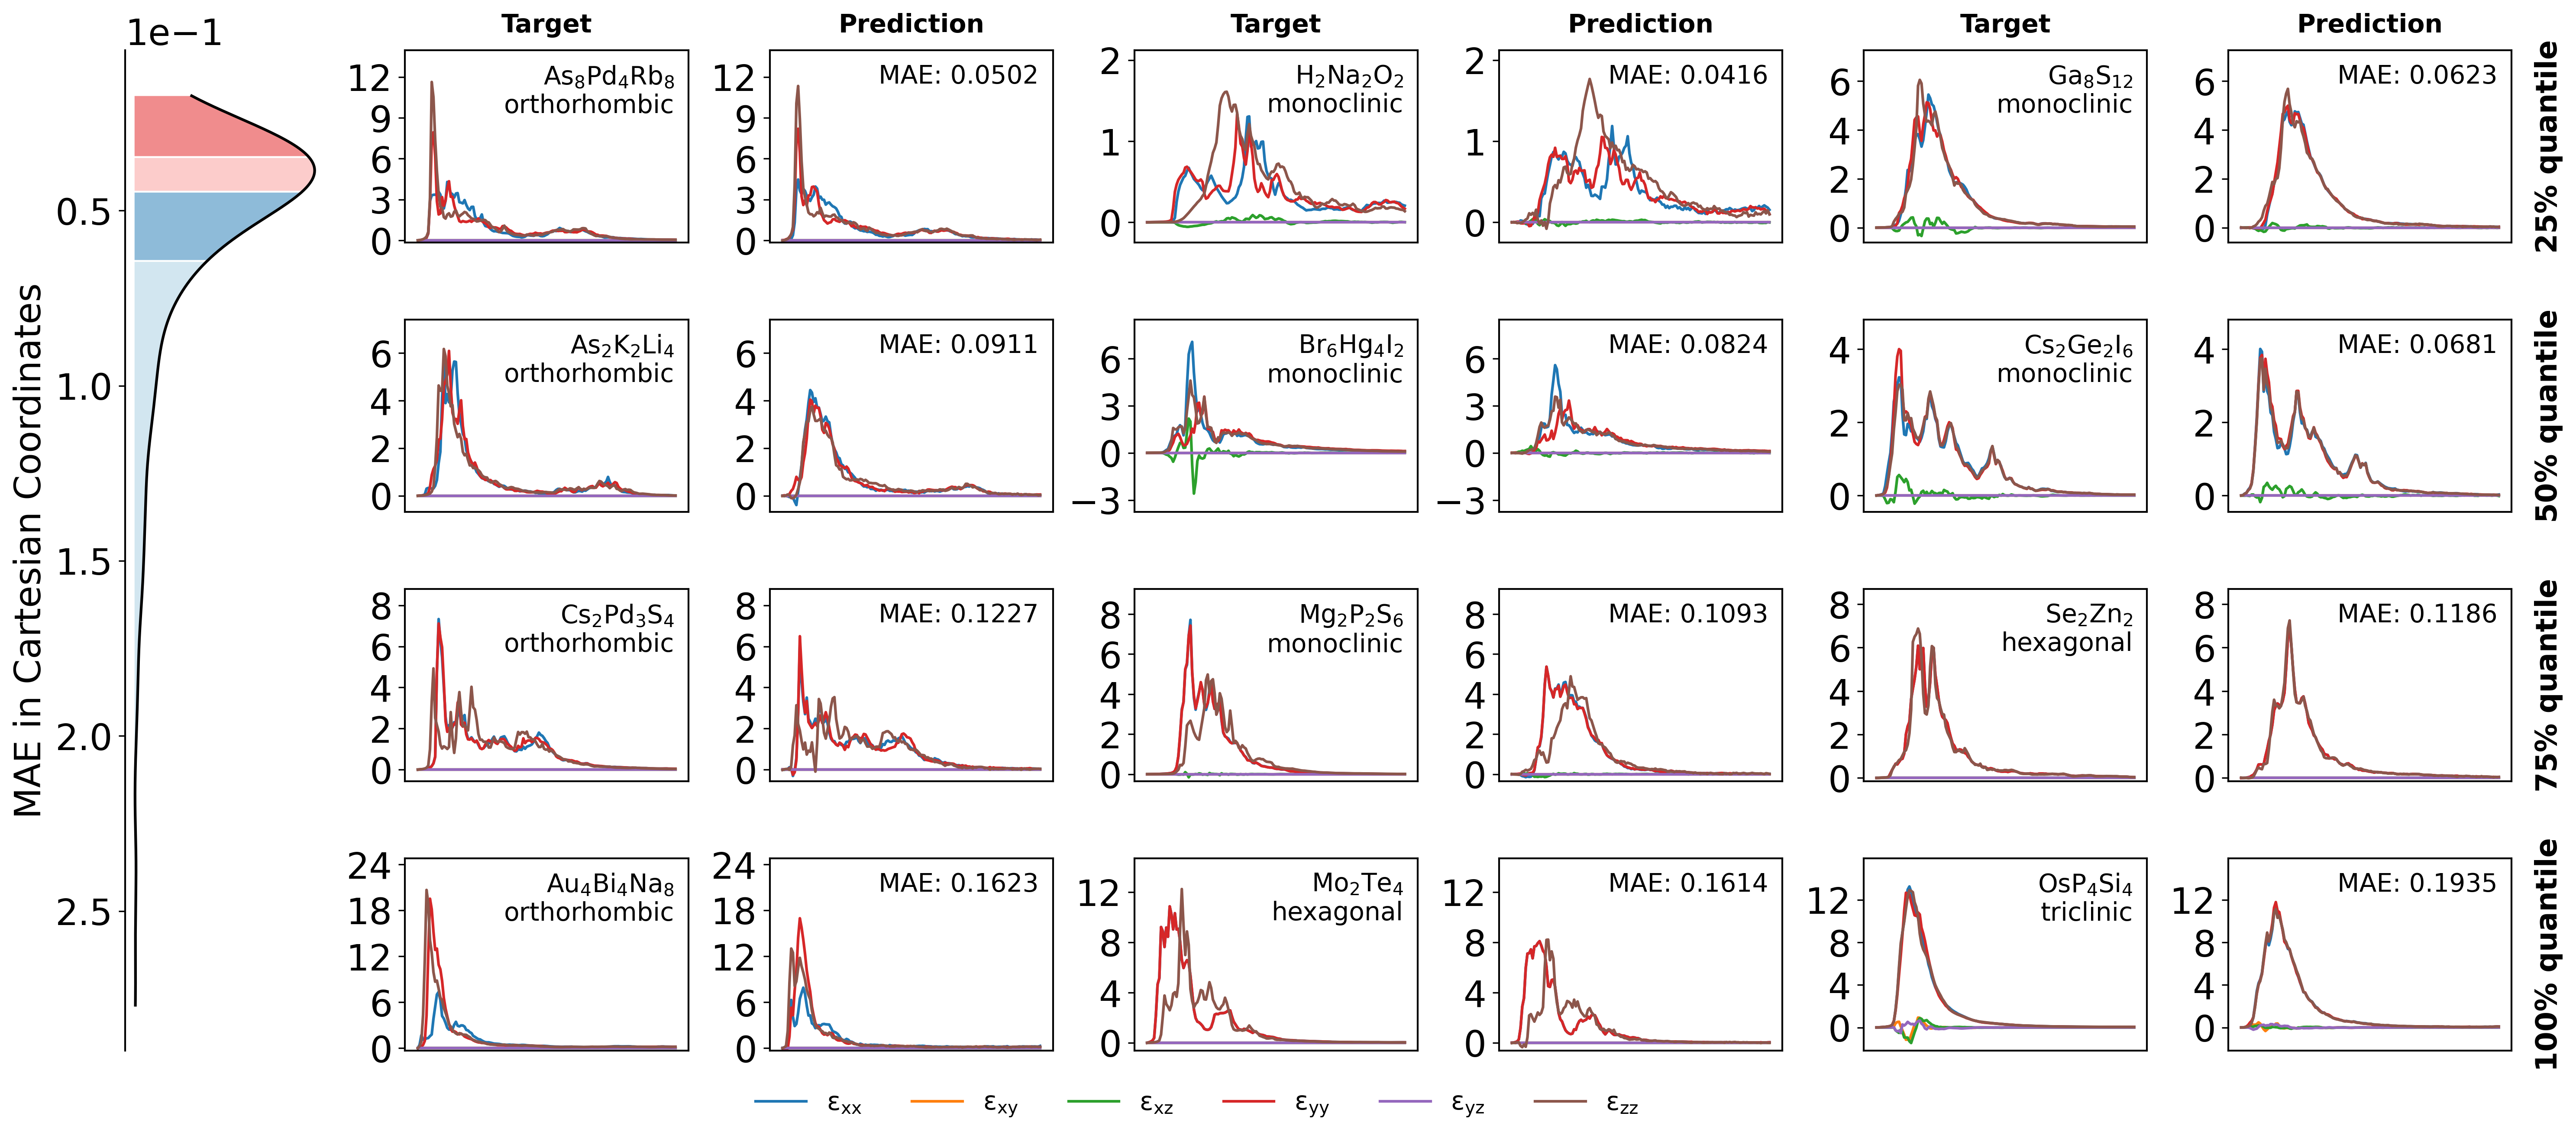

In [29]:
# ======================================================
# Sample indices by quartiles
# ======================================================
def sample_by_mae_quartiles(df, idx_test, n_per_quartile=3):
    df_test = df.loc[idx_test].copy().reset_index()

    try:
        df_test["mae_quartile"] = pd.qcut(
            df_test["mae_cart"].rank(method="first"),
            q=4,
            labels=False,
            duplicates="drop"
        )
    except ValueError as e:
        print("Warning:", e)
        return []

    grouped_indices = []
    for q in range(4):
        q_bin = df_test[df_test["mae_quartile"] == q]
        if len(q_bin) == 0:
            continue
        sampled = q_bin.sample(min(n_per_quartile, len(q_bin)), random_state=3407) # 2, 10 還行
        grouped_indices.append(sampled["index"].tolist())

    return grouped_indices


# ======================================================
# Quartile KDE
# ======================================================
def plot_quartile_kde(ax, mae_cart, colors):
    y_max = np.quantile(mae_cart, 0.995)
    y = np.linspace(mae_cart.min(), y_max, 500)
    # y = np.linspace(mae_cart.min(), mae_cart.max(), 500)
    kde = gaussian_kde(mae_cart)
    p = kde.pdf(y)

    quartiles = np.quantile(mae_cart, (0.25, 0.5, 0.75, 1.0))
    qs = list(quartiles)[::-1] + [0]

    ax.plot(p, y, color="black")

    for i in range(len(qs)-1):
        mask = (y >= qs[i+1]) & (y <= qs[i])   # slice of y within this quartile
        ax.fill_betweenx(y[mask], 0, p[mask], color=colors[i], lw=0, alpha=0.5)
    ax.set_ylabel("MAE in Cartesian Coordinates")
    ax.set_xticks([])
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.invert_yaxis()
    for spine in ["top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

# ======================================================
# Combined plotting
# ======================================================
def plot_cartesian_tensor_comparison_by_quartile(df, grouped_idx, column_name,
                                                 mae_cart, title_prefix=""):
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\\epsilon_{{{xyz_list[a]}{xyz_list[b]}}}$"
                         for a in range(3) for b in range(a, 3)]
    colors = ["#a6cee3", "#1f78b4", "#fb9a99", "#e31a1c"]

    # Layout: 4 rows, KDE column + 6 spectra columns
    fig = plt.figure(figsize=(22, 10), dpi=300)
    gs = GridSpec(4, 7, width_ratios=[0.7] + [1]*6, wspace=0.3, hspace=0.4)

    # Left KDE
    ax_kde = fig.add_subplot(gs[:, 0])
    plot_quartile_kde(ax_kde, mae_cart, colors)

    handles, labels = [], []
    sample_idx = 0
    rightmost_ax_per_row = [None] * len(grouped_idx)

    # Spectra grid (4 rows, 6 columns = 3 systems per row * [real,pred])
    for row_idx, quartile_group in enumerate(grouped_idx):
        last_ax_pred = None
        for col_idx, idx_val in enumerate(quartile_group):
            ds_row = df.loc[idx_val]
            omega = ds_row["energies_interp"]
            real = ds_row[column_name]
            pred = ds_row["y_pred_cart"]
            formula = format_chemical_formula(ds_row["formula"])
            system = ds_row["crystal_system"]
            mae = ds_row["mae_cart"]

            y_min = min(real.min(), pred.min())
            y_max = max(real.max(), pred.max())

            # assign two axes: real vs pred
            ax_real = fig.add_subplot(gs[row_idx, col_idx*2+1])
            ax_pred = fig.add_subplot(gs[row_idx, col_idx*2+2])
            last_ax_pred = ax_pred

            for i, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
                h, = ax_real.plot(omega, real[:, a, b], label=tensor_components[i])
                ax_pred.plot(omega, pred[:, a, b])
                if sample_idx == 0:
                    handles.append(h)
                    labels.append(tensor_components[i])

            for ax in (ax_real, ax_pred):
                ax.set_ylim((y_min - 0.1) * 1.4, y_max * 1.2)
                ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
                ax.set_xticks([])
            if row_idx == 0:
                ax_real.set_title("Target", fontsize=14, pad=10, fontweight="bold")
                ax_pred.set_title("Prediction", fontsize=14, pad=10, fontweight="bold")

            ax_real.text(0.95, 0.93, f"${formula}$\n{system}",
                         transform=ax_real.transAxes, fontsize=14,
                         va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax_pred.text(0.95, 0.93, f"MAE: {mae:.4f}",
                         transform=ax_pred.transAxes, fontsize=14,
                         va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            sample_idx += 1

        rightmost_ax_per_row[row_idx] = last_ax_pred

    # Leave margin on the right
    fig.subplots_adjust(right=0.96)

    # Add quantile labels aligned with rows
    row_labels = ["25% quantile", "50% quantile", "75% quantile", "100% quantile"]
    for row_idx, ax_right in enumerate(rightmost_ax_per_row):
        if ax_right is None:
            continue
        bbox = ax_right.get_position()
        x = bbox.x1 + 0.008
        y = 0.5 * (bbox.y0 + bbox.y1)
        fig.text(x, y, row_labels[row_idx],
                 fontsize=16, fontweight="bold",
                 va="center", ha="left", rotation=90)

    fig.legend(handles, labels, loc="lower center",
               bbox_to_anchor=(0.5, 0.04), ncol=6, fontsize=14, frameon=False)

    os.makedirs("../pngs", exist_ok=True)
    fig.savefig(f"../pngs/{title_prefix}_quartile_combined.png", dpi=300)
    plt.show()

# ======================================================
# Usage
# ======================================================
grouped_idx = sample_by_mae_quartiles(df, idx_test, n_per_quartile=3)
plot_cartesian_tensor_comparison_by_quartile(
    df, grouped_idx, column_name=column, mae_cart=df['mae_cart'],
    title_prefix="mae_quartiles"
)

In [5]:
df_train = df.loc[idx_train].copy().reset_index()
df_valid = df.loc[idx_valid].copy().reset_index()
df_test = df.loc[idx_test].copy().reset_index()

# print(df_train['mae_cart'].mean())
# print(df_valid['mae_cart'].mean())
# print(df_test['mae_cart'].mean())

print(df_test['mae_cart_xx'].mean())
print(df_test['mae_cart_yy'].mean())
print(df_test['mae_cart_zz'].mean())
print(df_test['mae_cart_xz'].mean())
print(df_test['mae_cart_xy'].mean())
print(df_test['mae_cart_yz'].mean())
df_mono = df[df["crystal_system"] == "monoclinic"]
mean_mae_xz = df_mono["mae_cart_xz"].mean()
std_mae_xz = df_mono["mae_cart_xz"].std()
median_mae_xz = df_mono["mae_cart_xz"].median()

print(f"Monoclinic mae_cart_xz: {mean_mae_xz:.4f} ± {std_mae_xz:.4f}")
print(f"Monoclinic mae_cart_xz: {median_mae_xz:.4f}")

0.2096623803946186
0.20753638638220803
0.2301096641556395
0.008877118524261271
0.0017763465656166451
0.0016052308884982435
Monoclinic mae_cart_xz: 0.0350 ± 0.0332
Monoclinic mae_cart_xz: 0.0237


# sampled

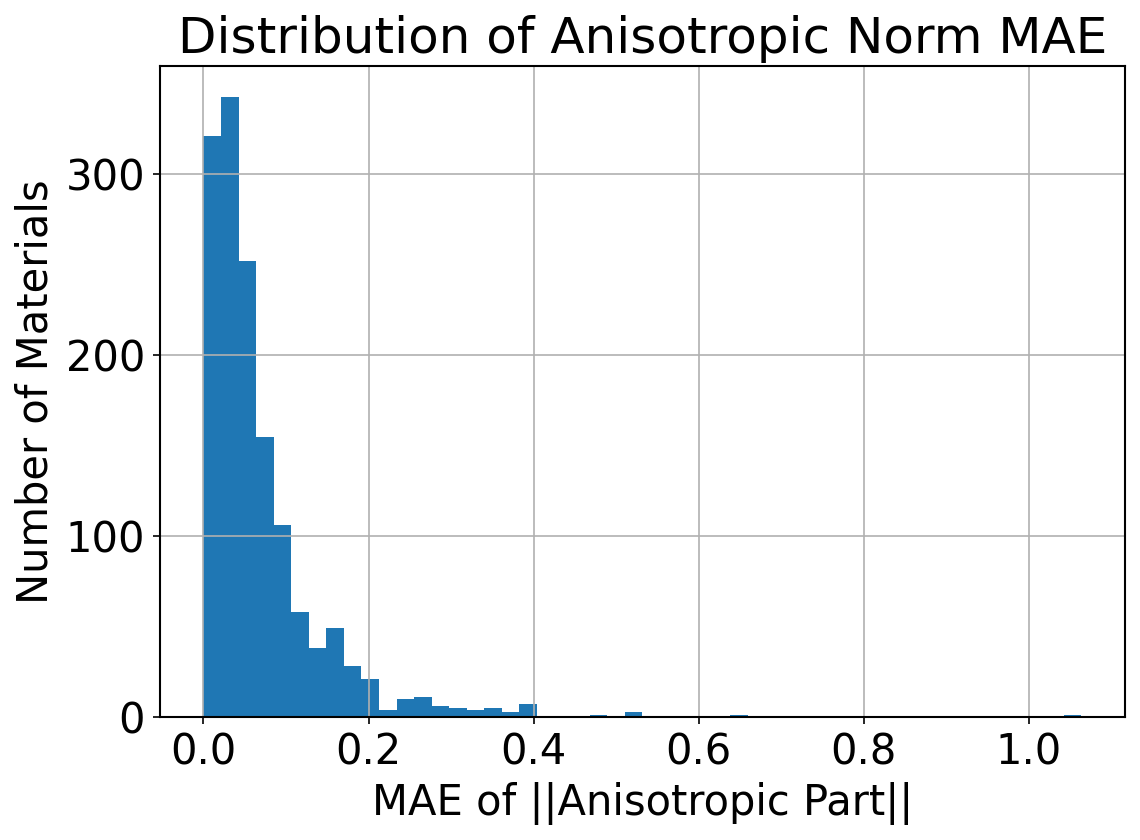

Mean MAE: 0.0669
Standard Deviation: 0.0778


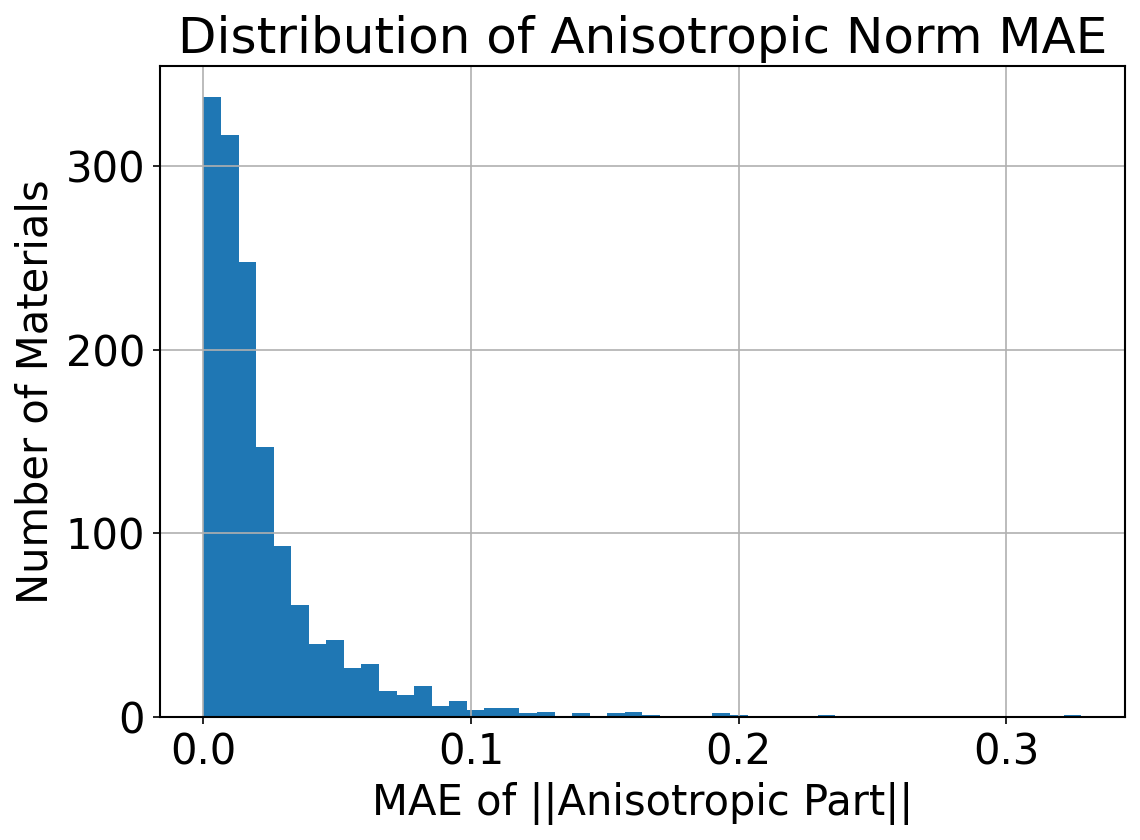

Mean MAE: 0.0223
Standard Deviation: 0.0274


In [6]:
def decompose_tensor_seq(tensor_seq):
    iso_parts = []
    aniso_parts = []
    for tensor in tensor_seq:
        iso, aniso = decompose_tensor((tensor + tensor.T.conj()) / 2)
        iso_parts.append(iso)
        aniso_parts.append(aniso)
    return np.array(iso_parts), np.array(aniso_parts)

def decompose_tensor(tensor):
    """
    Input: tensor of shape (3, 3)
    Returns: (iso_part, aniso_part), both (3, 3)
    """
    iso_scalar = np.trace(tensor) / 3
    iso_part = iso_scalar * np.eye(3)
    aniso_part = tensor - iso_part
    return iso_part, aniso_part

def anisotropy_strength(aniso_seq):
    return np.linalg.norm(aniso_seq, axis=(1,2))  # [n_freq]

def compute_aniso_mae(row):
    true_tensor = row["rel_permittivity_imag_interp"]  # shape (N_ω, 3, 3)
    pred_tensor = row["y_pred_cart"]

    # Decompose into isotropic + anisotropic parts
    true_iso, true_aniso = decompose_tensor_seq(true_tensor)
    pred_iso, pred_aniso = decompose_tensor_seq(pred_tensor)

    # --- (1) Component-wise anisotropic MAE ---
    # flatten component-wise tensors across all ω
    comp_diff = np.abs(true_aniso - pred_aniso)  # shape (N_ω, 3, 3)
    triu_idx = np.triu_indices(3)
    comp_diff_unique = comp_diff[:, triu_idx[0], triu_idx[1]]
    comp_mae = np.mean(comp_diff_unique[np.isfinite(comp_diff_unique)])

    # --- (2) Anisotropy strength MAE ---
    true_norm = anisotropy_strength(true_aniso)  # (N_ω,)
    pred_norm = anisotropy_strength(pred_aniso)  # (N_ω,)

    mask = np.isfinite(true_norm) & np.isfinite(pred_norm)
    if np.sum(mask) == 0:
        return pd.Series({"aniso_comp_mae": np.nan, "aniso_norm_mae": np.nan})

    norm_mae = np.mean(np.abs(true_norm[mask] - pred_norm[mask]))

    return pd.Series({
        "aniso_comp_mae": comp_mae,
        "aniso_norm_mae": norm_mae
    })


df[["aniso_comp_mae", "aniso_norm_mae"]] = df.apply(compute_aniso_mae, axis=1)
plt.figure(figsize=(8, 6))
df['aniso_norm_mae'].dropna().hist(bins=50)
plt.xlabel("MAE of ||Anisotropic Part||")
plt.ylabel("Number of Materials")
plt.title("Distribution of Anisotropic Norm MAE")
plt.tight_layout()
plt.show()
mean_mae = df['aniso_norm_mae'].mean()
std_mae = df['aniso_norm_mae'].std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Standard Deviation: {std_mae:.4f}")

plt.figure(figsize=(8, 6))
df['aniso_comp_mae'].dropna().hist(bins=50)
plt.xlabel("MAE of ||Anisotropic Part||")
plt.ylabel("Number of Materials")
plt.title("Distribution of Anisotropic Norm MAE")
plt.tight_layout()
plt.show()
mean_mae = df['aniso_comp_mae'].mean()
std_mae = df['aniso_comp_mae'].std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Standard Deviation: {std_mae:.4f}")

Dropped 26 cubic systems, 121 remaining


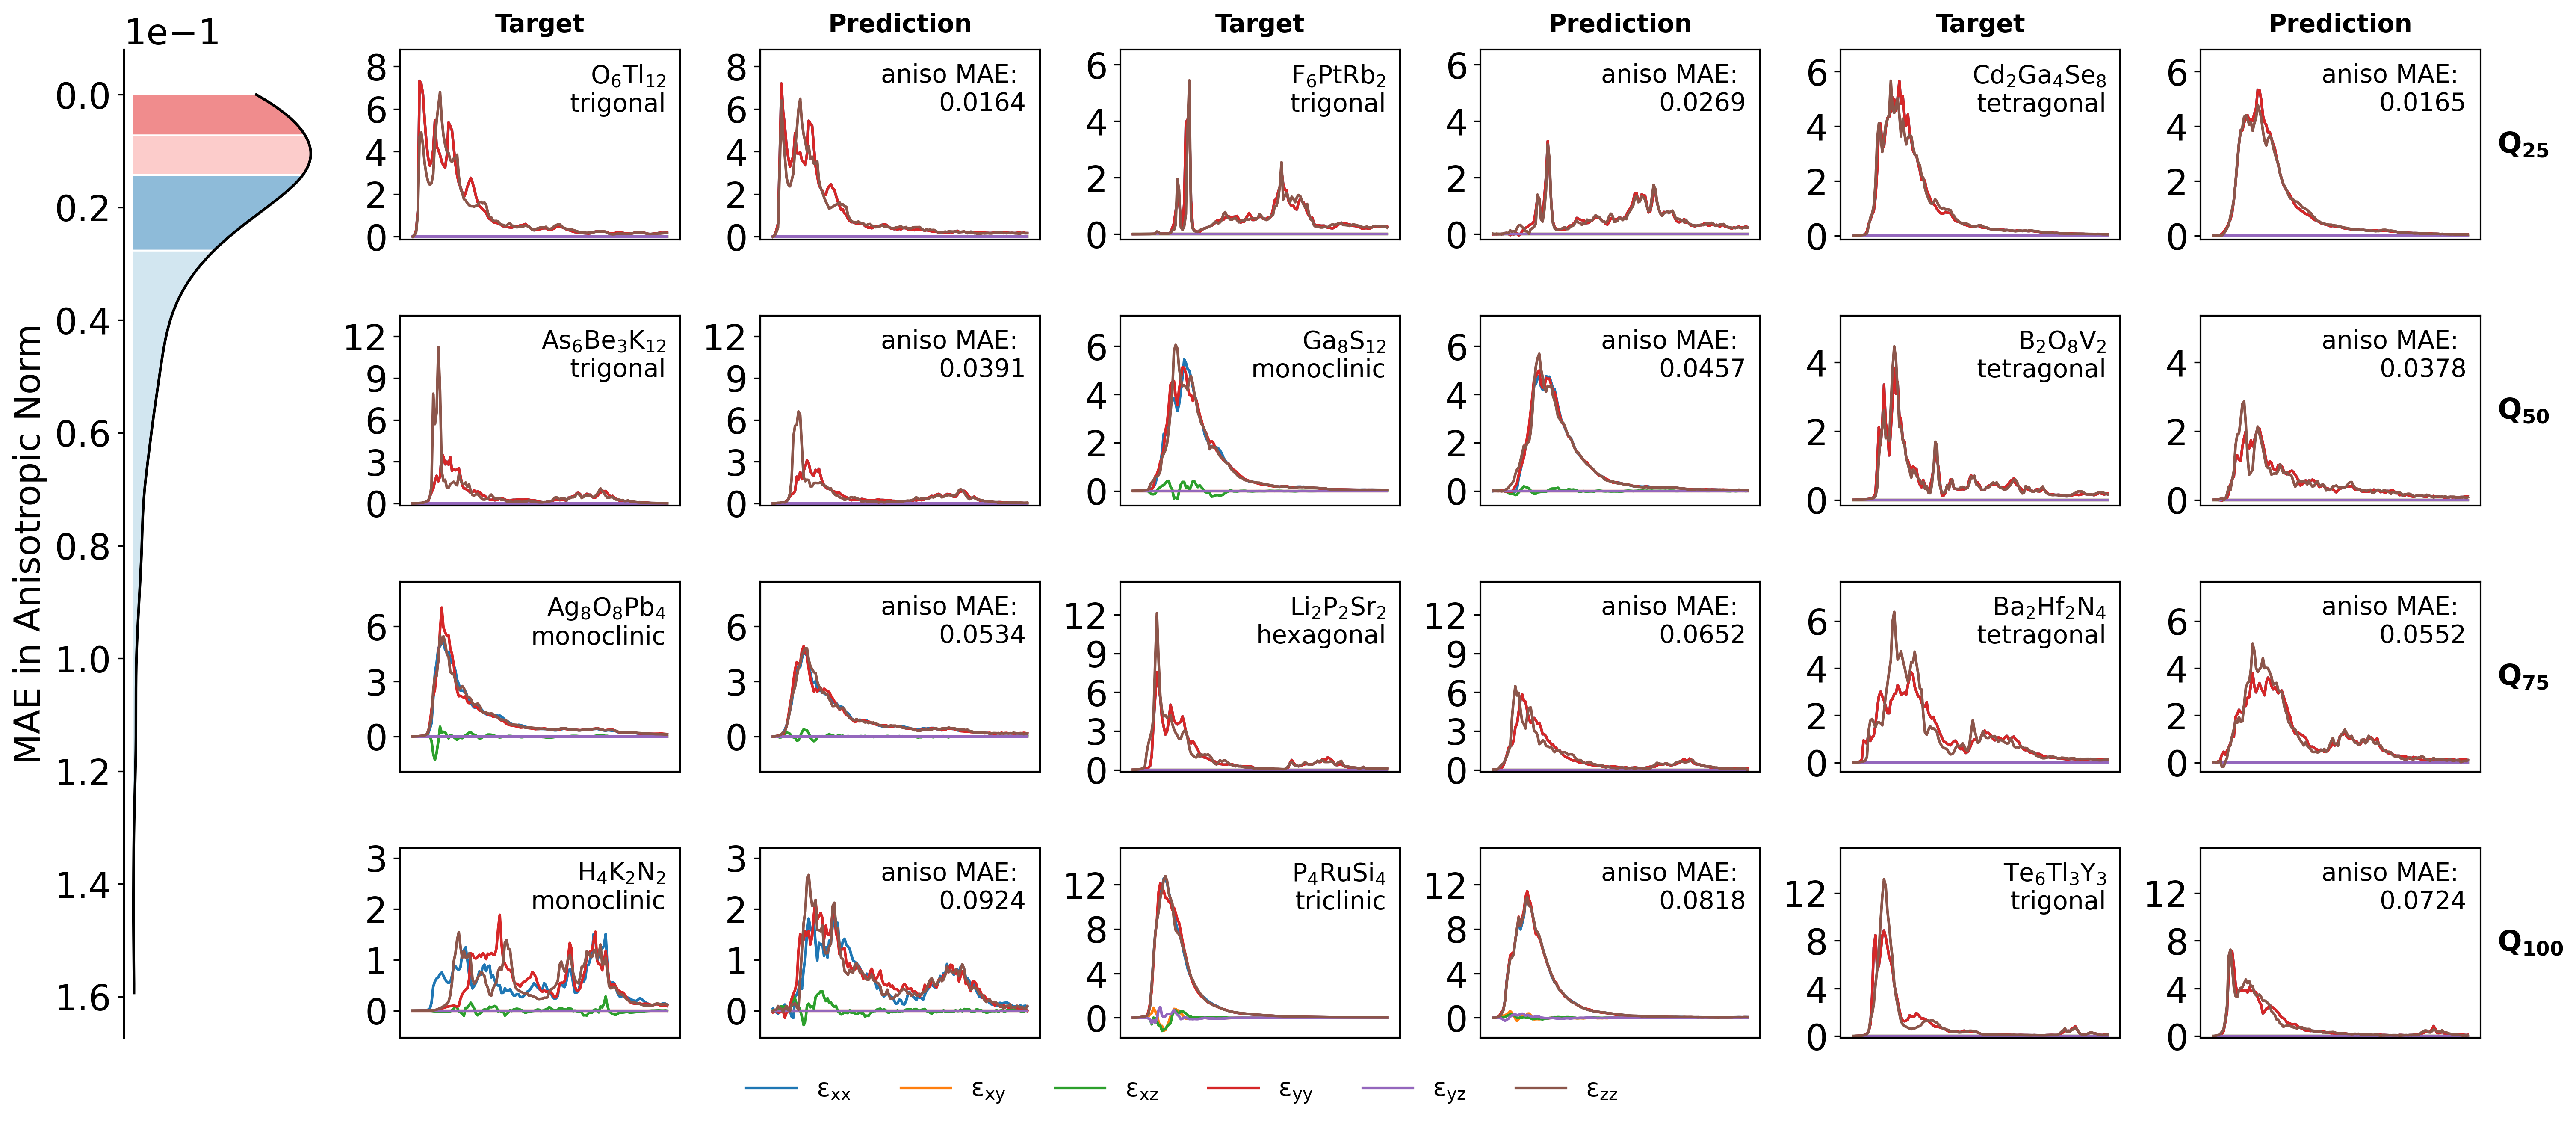

In [30]:
# ======================================================
# Sample indices by quartiles
# ======================================================
def sample_by_aniso_mae_quartiles(df, idx_test, n_per_quartile=3, drop_cubic=True):
    df_test = df.loc[idx_test].copy().reset_index()

    # Drop cubic materials (isotropic by symmetry)
    if drop_cubic:
        before = len(df_test)
        df_test = df_test[df_test["crystal_system"].str.lower() != "cubic"]
        after = len(df_test)
        print(f"Dropped {before - after} cubic systems, {after} remaining")

    try:
        df_test["aniso_mae_quartile"] = pd.qcut(
            df_test["aniso_comp_mae"].rank(method="first"),
            q=4,
            labels=False,
            duplicates="drop"
        )
    except ValueError as e:
        print("Warning:", e)
        return []

    grouped_indices = []
    for q in range(4):
        q_bin = df_test[df_test["aniso_mae_quartile"] == q]
        if len(q_bin) == 0:
            continue
        sampled = q_bin.sample(min(n_per_quartile, len(q_bin)), random_state=71) # 18, 71, 3403, 3407 不錯
        grouped_indices.append(sampled["index"].tolist())

    return grouped_indices


# ======================================================
# Quartile KDE
# ======================================================
def plot_quartile_kde(ax, mae_cart, colors):
    # y = np.linspace(mae_cart.min(), mae_cart.max(), 500)
    y_max = np.quantile(mae_cart, 0.995)
    y = np.linspace(mae_cart.min(), y_max, 500)
    kde = gaussian_kde(mae_cart)
    p = kde.pdf(y)

    quartiles = np.quantile(mae_cart, (0.25, 0.5, 0.75, 1.0))
    qs = list(quartiles)[::-1] + [0]

    ax.plot(p, y, color="black")
    for i in range(len(qs)-1):
        mask = (y >= qs[i+1]) & (y <= qs[i])   # slice of y within this quartile
        ax.fill_betweenx(y[mask], 0, p[mask], color=colors[i], lw=0, alpha=0.5)
    ax.set_ylabel("MAE in Anisotropic Norm")
    ax.set_xticks([])
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.invert_yaxis()
    for spine in ["top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

# ======================================================
# Combined plotting
# ======================================================
def plot_cartesian_tensor_comparison_by_quartile(df, grouped_idx, column_name,
                                                 mae_cart, title_prefix=""):
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\\epsilon_{{{xyz_list[a]}{xyz_list[b]}}}$"
                         for a in range(3) for b in range(a, 3)]
    colors = ["#a6cee3", "#1f78b4", "#fb9a99", "#e31a1c"]

    # Layout: 4 rows, KDE column + 6 spectra columns
    fig = plt.figure(figsize=(22, 10), dpi=300)
    gs = GridSpec(4, 7, width_ratios=[0.7] + [1]*6, wspace=0.3, hspace=0.4)

    # Left KDE
    ax_kde = fig.add_subplot(gs[:, 0])
    plot_quartile_kde(ax_kde, mae_cart, colors)

    handles, labels = [], []
    sample_idx = 0

    # Track the rightmost axis in each row to anchor the labels later
    rightmost_ax_per_row = [None] * len(grouped_idx)

    # Spectra grid (4 rows, 6 columns = 3 systems per row * [real,pred])
    for row_idx, quartile_group in enumerate(grouped_idx):
        last_ax_pred = None
        for col_idx, idx_val in enumerate(quartile_group):
            ds_row = df.loc[idx_val]
            omega = ds_row["energies_interp"]
            real = ds_row[column_name]
            pred = ds_row["y_pred_cart"]
            formula = format_chemical_formula(ds_row["formula"])
            system = ds_row["crystal_system"]
            aniso_mae = ds_row["aniso_comp_mae"]

            y_min = min(real.min(), pred.min())
            y_max = max(real.max(), pred.max())

            # assign two axes: real vs pred
            ax_real = fig.add_subplot(gs[row_idx, col_idx*2+1])
            ax_pred = fig.add_subplot(gs[row_idx, col_idx*2+2])
            last_ax_pred = ax_pred  # keep updating; the last one is rightmost

            for i, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
                h, = ax_real.plot(omega, real[:, a, b], label=tensor_components[i])
                ax_pred.plot(omega, pred[:, a, b])
                if sample_idx == 0:
                    handles.append(h)
                    labels.append(tensor_components[i])

            for ax in (ax_real, ax_pred):
                ax.set_ylim((y_min - 0.1) * 1.4, y_max * 1.2)
                ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
                ax.set_xticks([])
            if row_idx == 0:
                ax_real.set_title("Target", fontsize=14, pad=10, fontweight="bold")
                ax_pred.set_title("Prediction", fontsize=14, pad=10, fontweight="bold")
            ax_real.text(0.95, 0.93, f"${formula}$\n{system}",
                         transform=ax_real.transAxes, fontsize=14,
                         va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax_pred.text(0.95, 0.93, f"aniso MAE: \n{aniso_mae:.4f}",
                         transform=ax_pred.transAxes, fontsize=14,
                         va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            sample_idx += 1

        # remember the true rightmost axis for this row
        rightmost_ax_per_row[row_idx] = last_ax_pred

    # Make room on the right for labels
    fig.subplots_adjust(right=0.96)

    # Use actual axes positions to place Q-labels perfectly aligned
    row_labels = [r"$Q_{25}$", r"$Q_{50}$", r"$Q_{75}$", r"$Q_{100}$"]
    for row_idx, ax_right in enumerate(rightmost_ax_per_row):
        if ax_right is None:
            continue
        bbox = ax_right.get_position()  # in figure coordinates
        x = bbox.x1 + 0.006            # small pad to the right of the row
        y = 0.5 * (bbox.y0 + bbox.y1)  # vertical center of the row
        fig.text(x, y, row_labels[row_idx],
                 fontsize=16, fontweight="bold",
                 va="center", ha="left", rotation=0)

    fig.legend(handles, labels, loc="lower center",
               bbox_to_anchor=(0.5, 0.04), ncol=6, fontsize=14, frameon=False)

    os.makedirs("../pngs", exist_ok=True)
    fig.savefig(f"../pngs/{title_prefix}_quartile_combined.png", dpi=300)
    plt.show()



# ======================================================
# Usage
# ======================================================
grouped_idx = sample_by_aniso_mae_quartiles(df, idx_test, n_per_quartile=3)
plot_cartesian_tensor_comparison_by_quartile(
    df, grouped_idx, column_name=column, mae_cart=df['aniso_comp_mae'],
    title_prefix="aniso_mae_quartile"
)

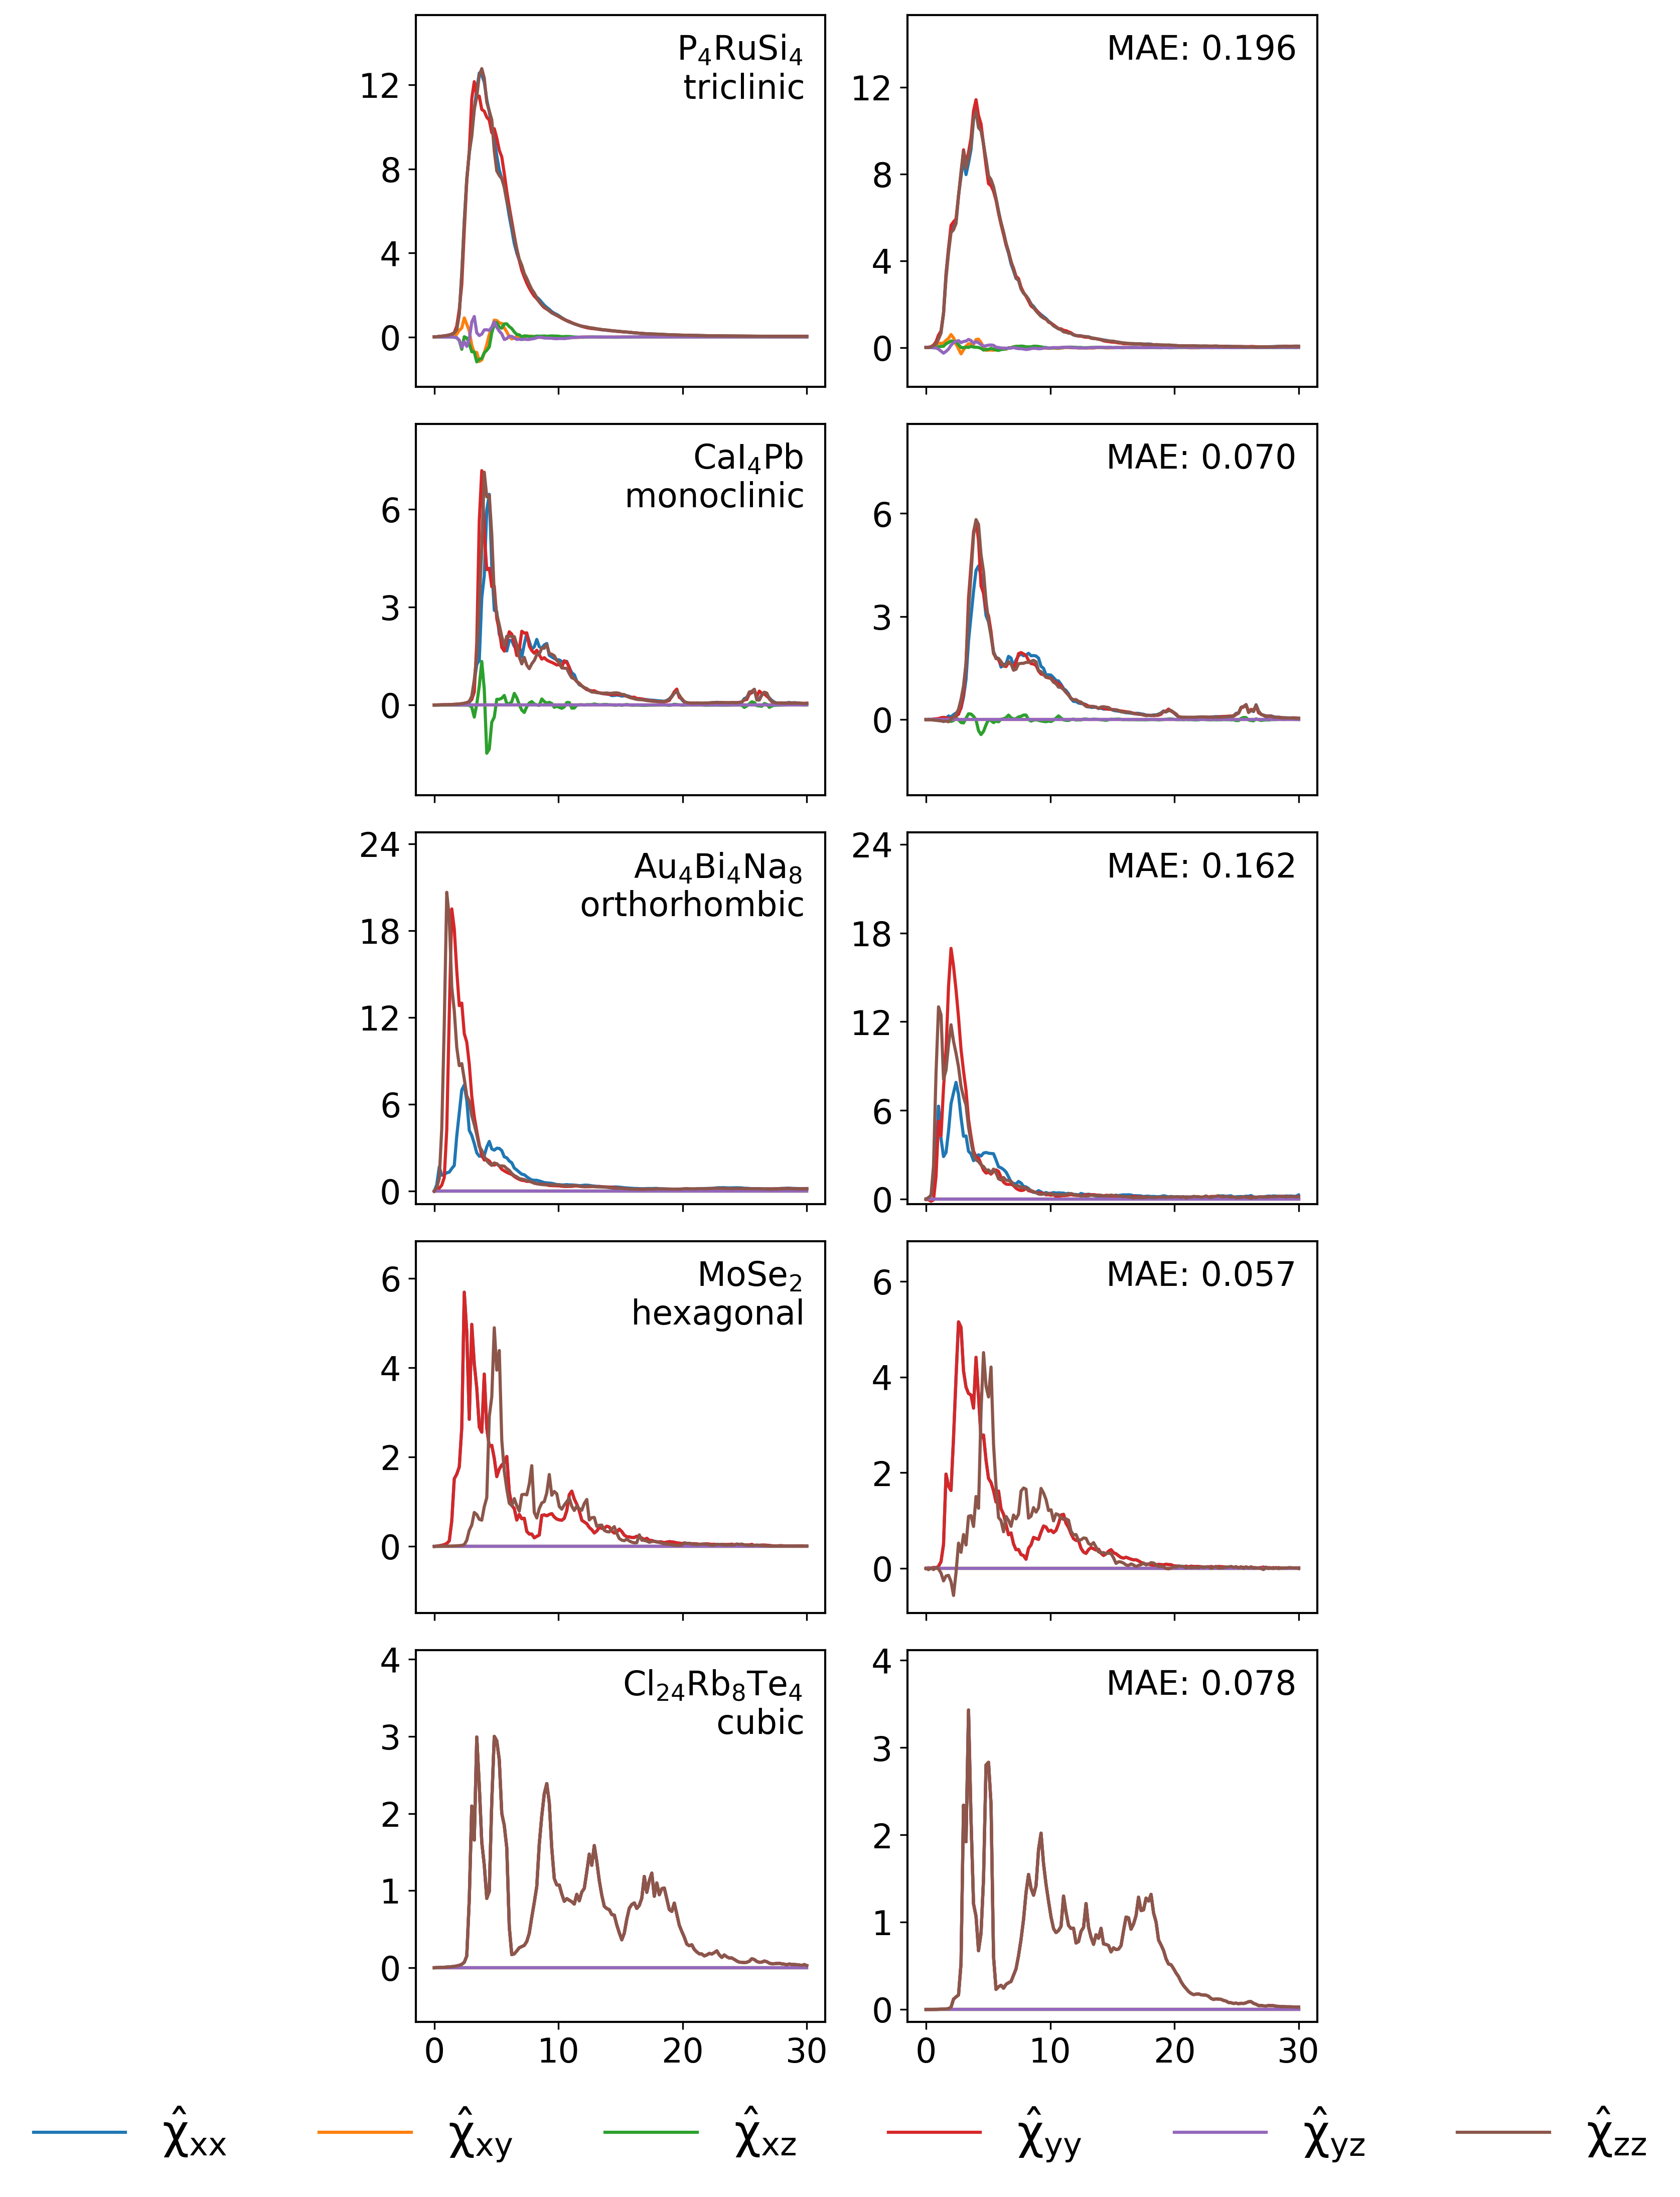

In [8]:
def get_one_sample_per_crystal_system(df, idx_test, target_systems):
    """
    Returns one index per crystal system from the test set, ordered from low to high symmetry.

    Parameters:
    - df: Full dataframe with 'crystal_system' column.
    - idx_test: List of indices belonging to the test set.
    - target_systems: List of crystal systems to include.

    Returns:
    - List of indices corresponding to one sample per crystal system, ordered by symmetry.
    """
    import random
    idx_test = list(idx_test)  # <-- COPY here, don't modify input!
    # random.seed(11)
    # random.seed(18)
    # random.seed(15)
    random.seed(102)
    random.shuffle(idx_test)

    # Define symmetry order from low to high
    symmetry_order = [
        "triclinic",
        "monoclinic",
        "orthorhombic",
        "tetragonal",
        "trigonal",
        "hexagonal",
        "cubic",
    ]

    # Filter the list to only those in target_systems, in the desired order
    ordered_targets = [s for s in symmetry_order if s in target_systems]

    # Create a lookup: crystal_system -> index
    system_to_index = {}
    seen_systems = set()

    for idx in idx_test:
        system = df.loc[idx, "crystal_system"]
        if system in ordered_targets and system not in seen_systems:
            system_to_index[system] = idx
            seen_systems.add(system)
        if len(seen_systems) == len(ordered_targets):
            break

    # Return indices in the desired symmetry order
    return [system_to_index[system] for system in ordered_targets if system in system_to_index]

    
    # return selected_indices
def plot_cartesian_tensor_comparison(df, idx, column_name, title_prefix="", n=3):
    """
    Plots multiple side-by-side line plots comparing predicted vs. real Cartesian tensors 
    in a more compact horizontal layout with minimal white space.

    Parameters:
    - df: Pandas DataFrame containing 'y_pred_cart' (predictions), 
          'real_Permittivity_Matrices_interp' (targets), and 'energies_interp'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title.
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    ds = df.iloc[idx].reset_index(drop=True)

    # Define component labels
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\hat{{\chi}}_{{{xyz_list[a]}{xyz_list[b]}}}$" for a in range(3) for b in range(a, 3)]

    # Define subplot grid layout
    n_rows = 5
    n_cols = 2  
    # Adjust figure size to reduce white space
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows), dpi=300, sharex=True)
    axes = axes.ravel()  # Flatten axes array for easy iteration

    handles, labels = [], []

    for i, sample_idx in enumerate(idx[:n]):  # Directly loop over provided idx
        material_id = ds.iloc[i]['mp_id']
        mae_cart = ds.iloc[i]['mae_cart']
        
        crystal_system = ds.iloc[i]['crystal_system']
        formula = ds.iloc[i]['formula']
        omega = ds["energies_interp"].iloc[i]
        formatted_formula = format_chemical_formula(formula)
        real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
        pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
        
        y_min = min(real_permittivity.min(), pred_permittivity.min())
        y_max = max(real_permittivity.max(), pred_permittivity.max())
        
        # Left subplot: Real permittivity
        ax_real = axes[2 * i]  # Every even index is real data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            h, = ax_real.plot(omega, real_permittivity[:, a, b], label=tensor_components[idx], linestyle='-')
            if i == 0:  # Collect legend items only from the first plot
                handles.append(h)
                labels.append(tensor_components[idx])
        if column_name =="real_Permittivity_Matrices_interp":
            ax_real.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_real.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        ax_real.text(0.95, 0.95, f"${formatted_formula}$ \n {crystal_system}", 
             transform=ax_real.transAxes, fontsize=16, verticalalignment='top', 
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        ax_real.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

        # Right subplot: Predicted permittivity
        ax_pred = axes[2 * i + 1]  # Every odd index is predicted data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            ax_pred.plot(omega, pred_permittivity[:, a, b], linestyle='-')
        if column_name =="real_Permittivity_Matrices_interp":
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)

        text_str = (
            f"{'MAE:':<1} {mae_cart:>4.3f}\n"
        )

        # Add the text to the subplot
        ax_pred.text(
            0.95, 0.95,  # Position in axes coordinates (top-right)
            text_str,
            transform=ax_pred.transAxes,
            fontsize=16,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
        ax_pred.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        
    # Remove x-labels from individual subplots
    for ax in axes:
        ax.set_xticks([])
        ax.tick_params(axis='y', labelsize=16)  # <-- Set the x-tick label size here
    for ax in axes[-n_cols:]:  
        ax.set_xticks(np.linspace(min(omega), max(omega), 4))
        ax.tick_params(axis='x', labelsize=16)  # <-- Set the x-tick label size here

    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=22, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
    plt.subplots_adjust(wspace=0.2, hspace=0.1)  

    os.makedirs("../pngs", exist_ok=True)
    save_path = f"../pngs/{title_prefix}_cart_spectra.png"
    fig.savefig(save_path, dpi=300)

    plt.show()

target_systems = ['triclinic', 'monoclinic', 'orthorhombic', 'hexagonal', 'cubic']
representative_idx = get_one_sample_per_crystal_system(df, idx_test, target_systems)

# Then pass it to your plotting function
plot_cartesian_tensor_comparison(df, representative_idx, column_name=column, title_prefix="five_crystal_systems", n=5)



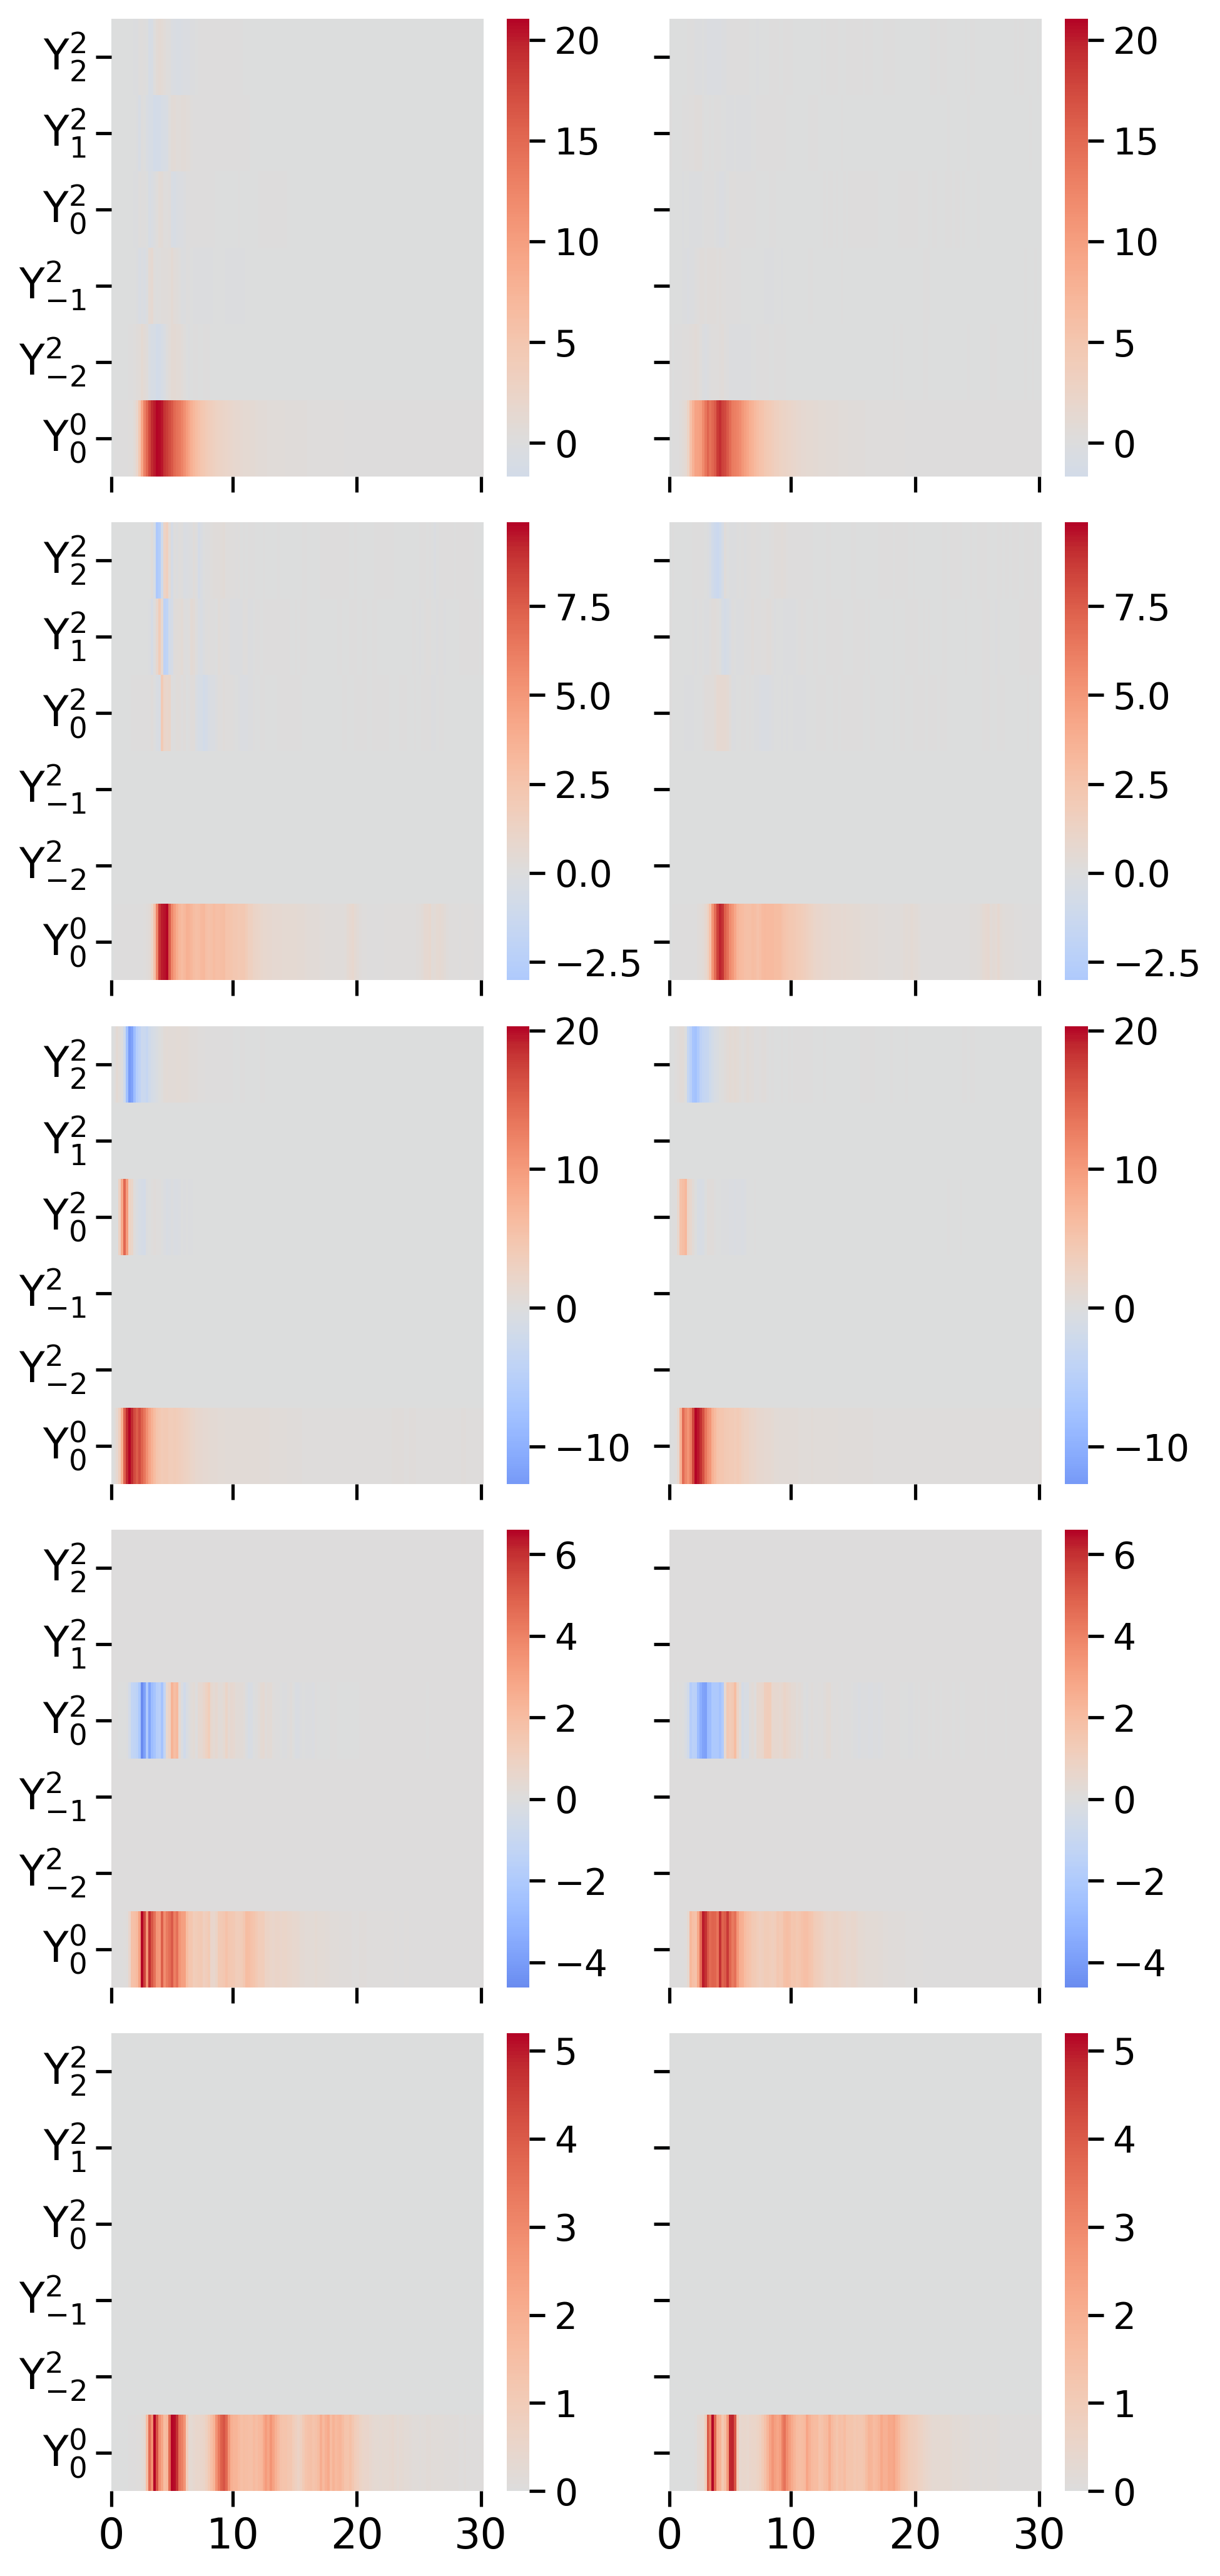

In [9]:
def plot_spherical_harmonics_comparison(df, idx, column_name, title_prefix="", n=4):
    """
    Plots heatmaps comparing target spherical harmonics with predicted spherical harmonics for multiple samples
    in a more compact layout (e.g., 4 rows × multiple columns instead of a single wide row).

    Parameters:
    - df: Pandas DataFrame containing 'sph_coefs' (targets), 'y_pred_sph' (predictions), 'mse'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title (e.g., Material ID).
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    from e3nn.io import CartesianTensor
    
    with sns.plotting_context("notebook", font_scale=2):
        ct = CartesianTensor("ij=ji")
        ds = df.iloc[idx].reset_index(drop=True)

        # Extract energy grid (assume shared for all)
        omega = df["energies_interp"].iloc[0]

        # Define subplot grid layout
        # n_rows = 4  # Fixed number of rows
        # n_cols = math.ceil(n / n_rows) * 2  # Ensures space for real & predicted pairs
        n_rows = 5
        n_cols = 2
        # Setup figure with multiple rows & columns for compact layout
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows), sharex=True, sharey=True, dpi=300)
        axes = axes.ravel()  # Flatten axes array for easy iteration

        # Spherical harmonic component labels
        component_ticks = [r"$Y^2_2$", r"$Y^2_{1}$", r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_{-2}$", r"$Y^0_0$"]
        # component_ticks = [
        #     r"",
        #     r"",
        #     r"",
        #     r"",
        #     r"",
        #     r""
        # ]

        for i, sample_idx in enumerate(idx[:n]):  # Use provided indices directly
            material_id = ds.iloc[i]['mp_id']
            crystal_system = ds.iloc[i]['crystal_system']
            real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
            pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
            perm = torch.tensor([1, 2, 0])  # Permutation: x->2, y->0, z->1

            # Convert to torch tensors if not already
            real_permittivity = torch.tensor(real_permittivity) if not torch.is_tensor(real_permittivity) else real_permittivity
            pred_permittivity = torch.tensor(pred_permittivity) if not torch.is_tensor(pred_permittivity) else pred_permittivity

            # Permute the 3x3 dimensions (axes 1 and 2)
            real_permittivity_permuted = real_permittivity[:, perm, :][:, :, perm]  # Shape: [201, 3, 3]
            pred_permittivity_permuted = pred_permittivity[:, perm, :][:, :, perm]  # Shape: [201, 3, 3]

            real_sph = ct.from_cartesian(real_permittivity_permuted)
            pred_sph = ct.from_cartesian(pred_permittivity_permuted)

            # Extract target and prediction, then transpose & reverse for correct visualization
            X_irrep_target = real_sph.numpy().T[::-1, :]
            X_irrep_pred = pred_sph.numpy().T[::-1, :]
            vmin = X_irrep_target.min()
            vmax = X_irrep_target.max()
            # Left: Target heatmap
            ax_target = axes[2 * i]
            sns.heatmap(X_irrep_target, cmap='coolwarm', center=0, ax=ax_target,
                        yticklabels=component_ticks, xticklabels=50,
                        vmin=vmin, vmax=vmax)

            ax_target.tick_params(axis='x', rotation=0, labelsize=16)  
            ax_target.tick_params(axis='y', rotation=0, labelsize=16)  

            # Right: Predicted heatmap
            ax_pred = axes[2 * i + 1]
            sns.heatmap(X_irrep_pred, cmap='coolwarm', center=0, ax=ax_pred,
                        yticklabels=component_ticks, xticklabels=50,
                        vmin=vmin, vmax=vmax)

            ax_pred.tick_params(axis='x', rotation=0, labelsize=16)  
            ax_pred.tick_params(axis='y', rotation=0, labelsize=16)  

        # Set x-axis ticks at reasonable intervals
        num_omega = len(omega)
        tick_indices = np.linspace(0, num_omega - 1, 4, dtype=int)  
        tick_labels = [int(round(omega[idx])) for idx in tick_indices]  

        for ax in axes[:2 * n]:
            if ax.collections:  
                cbar = ax.collections[0].colorbar
                cbar.ax.tick_params(labelsize=14)  # <-- make colorbar tick labels smaller
        for ax in axes[:2 * n]:  
            ax.set_xticks(tick_indices)
            ax.set_xticklabels(tick_labels)

        plt.tight_layout(rect=[0, 0.05, 1, 1])  
        plt.subplots_adjust(wspace=0.2, hspace=0.1)  
        os.makedirs("../pngs", exist_ok=True)
        save_path = f"../pngs/{title_prefix}_spectra.png"
        fig.savefig(save_path, dpi=300)

        plt.show()

plot_spherical_harmonics_comparison(df, representative_idx, column, title_prefix="testing_set", n=5)


In [10]:
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
# from pymatgen.io.ase import AseAtomsAdaptor  # Import the converter
# import numpy as np

# sym_prec = 1e-2
# tolerance = 1e-6

# all_masks = []
# test_df = df[df['split'] == 'Test']

# for index, row in test_df.iterrows():
#     # Convert ASE Atoms object to pymatgen Structure
#     ase_atoms = row.symmetrized_structure  # This is your ASE Atoms object
#     pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
#     # Now use the pymatgen Structure with SpacegroupAnalyzer
#     sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
#     refined_structure = sga_primitive.get_refined_structure()
#     refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
#     symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

#     x = np.ones([3, 3])
#     mask = np.zeros([3, 3])
#     for op in symmetry_operations:
#         R = op.rotation_matrix 
#         mask += R @ x @ R.T
#     mask /= len(symmetry_operations)
#     all_masks.append(mask) 

#     spectra = row["y_pred_cart"]  # Shape: (301, 3,3)
#     # spectra = row["imag_Permittivity_Matrices_interp"]

#     violations = []
#     for i in range(spectra.shape[0]):  # Loop over omega
#         S_matrix = spectra[i] # Reshape (9,) -> (3,3)
#         # Check symmetry constraint
#         residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
#         max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask

#         if max_deviation > tolerance:
#             violations.append((i, max_deviation))
#     sys = row["crystal_system"]
#     formula = row["formula"]
#     split = row["split"]
#     # Print results
#     if not violations:
#         # print(f"Material {row['mp_id']} pass check")
#         continue
#     else:
#         print(f"Material @ {index} {row['mp_id']} violates symmetry in {len(violations)} cases. {sys}. {formula} {split}")
#         # for index, dev in violations[:5]:  # Print first few violations
#             # print(f"  - Row {index}: max deviation = {dev:.5e}")

# # test_df["symmetry_mask"] = all_masks


In [11]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count  

def kramers_kronig_tensor(omega_vals, imag_tensor):
    N = len(omega_vals)
    real_tensor = np.zeros_like(imag_tensor)

    for i in range(3):
        for j in range(i, 3):
            chi_im_vals = imag_tensor[:, i, j]
            chi_re_vals = np.zeros(N)

            for k, omega in enumerate(omega_vals):
                integrand = np.zeros(N)
                for l, omega_p in enumerate(omega_vals):
                    if l != k: # Skip the singularity when omega' = omega
                        integrand[l] = (omega_p * chi_im_vals[l]) / (omega_p**2 - omega**2)
                integral = np.trapz(integrand, omega_vals)
                chi_re_vals[k] = (2 / np.pi) * integral

            real_tensor[:, i, j] = chi_re_vals
            if i != j:
                real_tensor[:, j, i] = chi_re_vals
    for i in range(3):
        real_tensor[:, i, i] += 1.0
        
    return real_tensor

def compute_K_xx(omega, sigma_complex):
    omega_cut = omega[1:]
    # sigma = sigma_complex[1:]  # shape: (N-5, 3, 3)
    sigma_xx_re = sigma_complex[1:, 0, 0].real
    integrand = np.nan_to_num(sigma_xx_re / omega_cut, nan=0.0, posinf=0.0, neginf=0.0)
    return 2 * np.trapz(integrand, omega_cut)

def compute_C_xy(omega, sigma_complex):
    omega_cut = omega[1:]
    sigma_xy_im = sigma_complex[1:, 0, 1].imag
    integrand = np.nan_to_num(sigma_xy_im / omega_cut, nan=0.0, posinf=0.0, neginf=0.0)
    return -4 * np.trapz(integrand, omega_cut)

def process_row(row_dict):
    row = row_dict.copy()
    imag_permittivity = row["rel_permittivity_imag_interp"]
    pred_imag_permittivity = row["y_pred_cart"]
    omega = row["energies_interp"]

    omega = np.where(omega == 0, np.finfo(float).eps, omega)
    
    real_permittivity = kramers_kronig_tensor(omega, imag_permittivity)
    pred_real_permittivity = kramers_kronig_tensor(omega, pred_imag_permittivity)

    permittivity_complex = real_permittivity + 1j * imag_permittivity
    conductivity_complex = -1j * permittivity_complex / omega[:, np.newaxis, np.newaxis]

    pred_permittivity_complex = pred_real_permittivity + 1j * pred_imag_permittivity
    pred_conductivity_complex = -1j * pred_permittivity_complex / omega[:, np.newaxis, np.newaxis]

    row["conductivity_complex"] = conductivity_complex
    row["pred_conductivity_complex"] = pred_conductivity_complex

    # Quantum weight and Chern number
    row["K_xx"] = compute_K_xx(omega, conductivity_complex)
    row["pred_K_xx"] = compute_K_xx(omega, pred_conductivity_complex)

    row["C_xy"] = compute_C_xy(omega, conductivity_complex)
    row["pred_C_xy"] = compute_C_xy(omega, pred_conductivity_complex)
    return row

# --- Parallelize over rows ---
num_workers = min(cpu_count(), len(df))  # Limit workers to available CPU cores

def parallel_process_df(df, n_workers=None):
    rows = df.to_dict(orient="records")
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_row, rows))
    return pd.DataFrame(results)

# Usage:
df = parallel_process_df(df)

R² score: 0.6306


/tmp/ipykernel_626983/1558034098.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name


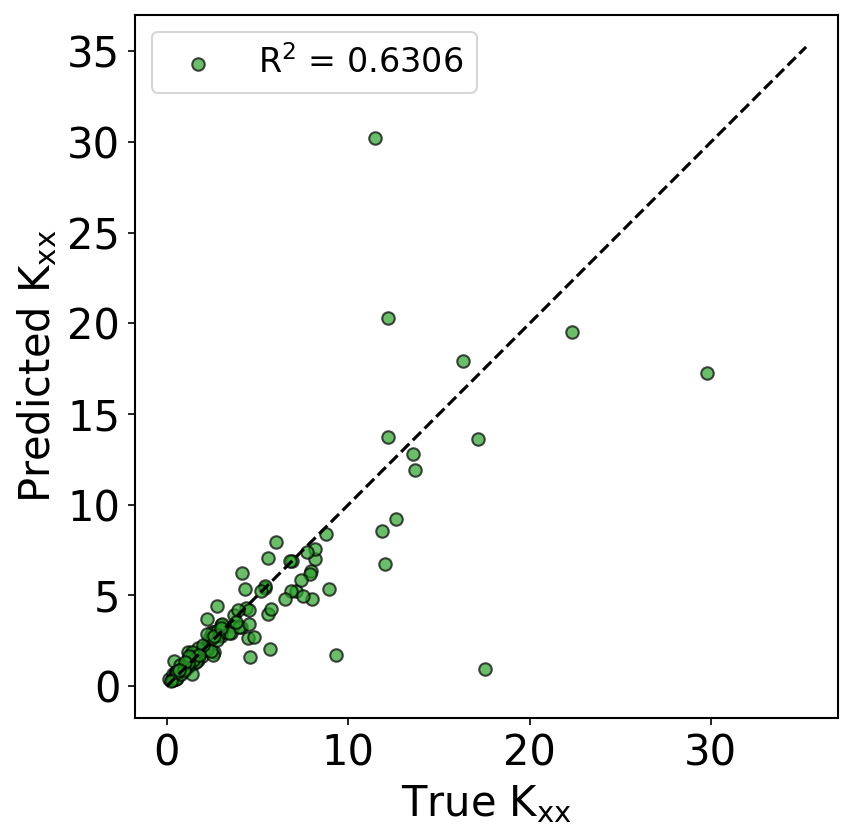

In [12]:
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name
df_clean = df[
    (df["split"] == "Test") & 
    (df["K_xx"] > 0) & (df["K_xx"] < 65) & 
    (df["pred_K_xx"] > 0) & (df["pred_K_xx"] < 65)
]

# Compute R²
r2 = r2_score(df_clean["K_xx"], df_clean["pred_K_xx"])
print(f"R² score: {r2:.4f}")

# Create plot
lims = [
    0,
    max(df_clean["K_xx"].max(), df_clean["pred_K_xx"].max())+5
]

plt.figure(figsize=(7,6))
plt.scatter(df_clean["K_xx"], df_clean["pred_K_xx"], alpha=0.7, edgecolor='k', color=colors["Test"], label=f"$R^2$ = {r2:.4f}")

# x = y line
plt.plot(lims, lims, 'k--')

# Make axes have equal scaling
plt.gca().set_aspect('equal', adjustable='box')

# Labels and layout
plt.xlabel("True $K_{xx}$")
plt.ylabel("Predicted $K_{xx}$")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Sort by K_xx descending and take top N
top_kxx_df = df.sort_values(by="pred_K_xx", ascending=False).head(10)  # change 10 to however many you want

# Display top entries
print(top_kxx_df[["formula","mp_id", "bandgap", "pred_K_xx", "K_xx", "crystal_system"]])  # adapt columns if needed# df[df.mp_id == "mp-34202"]

        formula       mp_id  bandgap  pred_K_xx        K_xx crystal_system
67    As2Ge2Te5    mp-14791   0.4092  87.631687  102.554599       trigonal
244         Hg8  mp-1184657   0.5663  60.177697   62.091553          cubic
248   Ni4Sn4Ti4   mp-924130   0.4527  58.533692   61.721030          cubic
264       Ni4P8      mp-486   0.3713  55.952748   91.679395     monoclinic
540   Al4Fe8Nb4   mp-865280   0.3207  54.434494   60.644026          cubic
371         Hg6  mp-1546032   0.4391  49.403218   56.458061     monoclinic
1017     Ge3Te3      mp-938   0.5565  47.473406   32.395427       trigonal
166   As2Li2Se4  mp-1079276   0.4896  45.823734  179.043920      triclinic
14    Al4Fe8Ta4   mp-867249   0.3242  42.155857   41.243167          cubic
279         Hg6  mp-2629196   0.4089  41.607168   11.422416     monoclinic


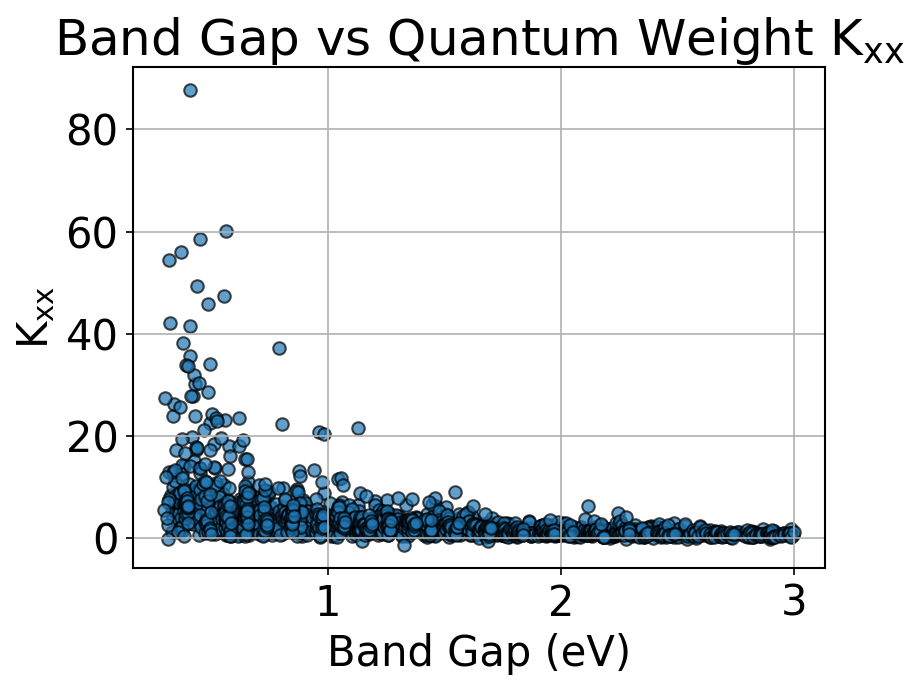

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(df["bandgap"], df["pred_K_xx"], alpha=0.7, edgecolor='k')
plt.xlabel("Band Gap (eV)")
plt.ylabel(r"$K_{xx}$")
plt.title("Band Gap vs Quantum Weight $K_{xx}$")
plt.grid(True)
plt.tight_layout()
plt.show()

R² score: 0.6656


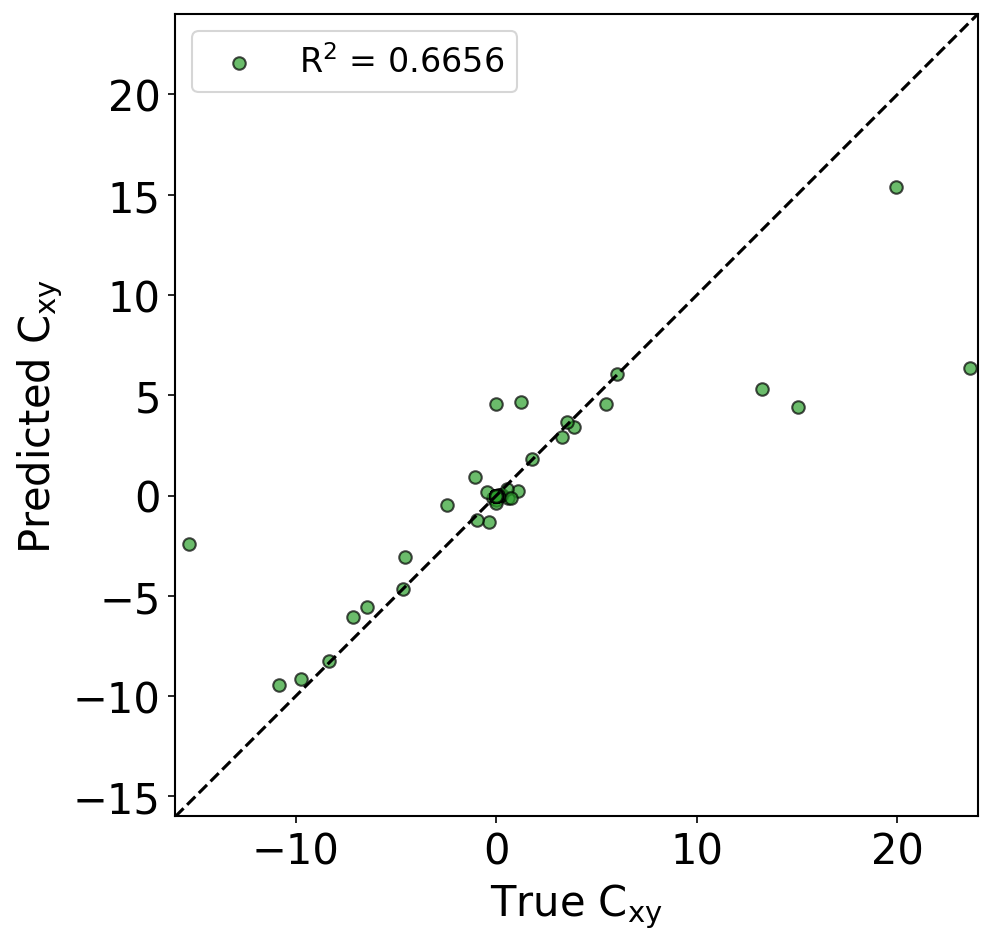

In [15]:
# Set up figure
plt.figure(figsize=(7,7))

# Scatter
# Compute R²
r2 = r2_score(df["C_xy"], df["pred_C_xy"])
print(f"R² score: {r2:.4f}")
plt.scatter(df["C_xy"], df["pred_C_xy"], alpha=0.7, edgecolor='k', color=colors["Test"], label=f"$R^2$ = {r2:.4f}")

# Determine axis range based on full data
x_min = min(df["C_xy"].min(), df["pred_C_xy"].min())
x_max = max(df["C_xy"].max(), df["pred_C_xy"].max())

# Round limits for neat ticks (optional)
x_min = np.floor(x_min)
x_max = np.ceil(x_max)

# Use equal limits for both axes
lims = [x_min, x_max]
plt.xlim(lims)
plt.ylim(lims)

# Add x = y line
plt.plot(lims, lims, 'k--')

# Enforce square aspect
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Set 54 evenly spaced ticks

# Labels and legend
plt.xlabel("True $C_{xy}$")
plt.ylabel("Predicted $C_{xy}$")
plt.legend()
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [16]:
# # Choose a row
# row = df[df["formula"] == "Cd2P8"].iloc[0]
# print(row.split)

# # Extract data
# omega = row.omega
# omega_interp = row.energies_interp

# imag_permittivity = row["y_pred_cart"]
# real_permittivity = interpolate_matrix(row["real_symmetrized_permittivity"], omega)
# real_permittivity_kkr = kramers_kronig_tensor(omega_interp, imag_permittivity)

# # Settings
# xyz_list = ['x', 'y', 'z']
# fontsize = 20
# figsize = (6, 18)
# threshold = 1e-4
# zoomed_out_ylim = 5e-1

# # Define which components to show: e.g., xx, yy, zz, xz
# components_to_plot = [(0, 0), (1, 1), (2, 2), (0, 2)]

# # Set up subplots: 4 vertically stacked
# fig, axes = plt.subplots(len(components_to_plot), 1, figsize=figsize, sharex=True, sharey= True, dpi = 150)
# if len(components_to_plot) == 1:
#     axes = [axes]  # ensure iterable

# lines = []
# labels = []
# maes = []

# for ax, (i, j) in zip(axes, components_to_plot):
#     y1 = real_permittivity[:, i, j]
#     y2 = real_permittivity_kkr[:, i, j]

#     l1, = ax.plot(omega_interp, y1, color='black', label='Kubo Formula', linewidth = 3)
#     l2, = ax.plot(omega_interp, y2, linestyle='--', color='red', label='KKR from predicted imaginary part',linewidth = 3)

#     y_vals = np.concatenate([y1, y2])
#     max_val = np.max(np.abs(y_vals))

#     if max_val < threshold:
#         ax.set_ylim(-zoomed_out_ylim, zoomed_out_ylim)

#     mae = np.mean(np.abs(y1 - y2))
#     maes.append(mae)

#     comp_label = rf"$\hat{{\chi}}_{{{xyz_list[i]}{xyz_list[j]}}}$"
#     ax.set_title(f"{comp_label}   (MAE = {mae:.3f})", fontsize=fontsize + 2)
#     if len(lines) == 0:
#         # Save handles & labels for completeness (optional)
#         lines.extend([l1, l2])
#         labels.extend([l.get_label() for l in (l1, l2)])
        
#         # Put the legend in a less busy spot for the first subplot
#         ax.legend(loc='upper right', fontsize= 12, frameon=True)


# # Global info
# formula = format_chemical_formula(row["formula"])
# crystal_sys = row["crystal_system"]
# global_mae = np.mean(maes)

# fig.suptitle(rf"${formula}$, {crystal_sys} ", fontsize=fontsize + 2, x = 0.55,  y=0.92)
# fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 4, y=0.09, x = 0.55)
# fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 4, x = 0.1)


# plt.tight_layout(rect=[0, 0.05, 1, 0.96])
# plt.show()

In [17]:
# # Choose a row
# # row = df[df["formula"] == "Mo3S2Se4"].iloc[0]
# # row = df[df["formula"] == "H2Na2O2"].iloc[0]
# # row = df[(df["split"] == "Test") & (df["crystal_system"] == "monoclinic")].sample(1).iloc[0]
# row = df[df["formula"] == "Ag8O8Pb4"].iloc[0]

# # Extract data
# omega = row.omega
# omega_interp = row.energies_interp
# imag_permittivity = row["y_pred_cart"]
# real_permittivity = interpolate_matrix(row["real_symmetrized_permittivity"], omega)
# real_permittivity_kkr = kramers_kronig_tensor(omega_interp, imag_permittivity)
# xyz_list = ['x', 'y', 'z']
# fontsize = 24
# figsize = (15, 8)

# # Set up subplots
# fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
# axes = axes.flatten()

# component_idx = 0
# lines = []
# labels = []
# maes = []
# all_vals = np.concatenate([
#     real_permittivity[:, np.triu_indices(3)[0], np.triu_indices(3)[1]],
#     real_permittivity_kkr[:, np.triu_indices(3)[0], np.triu_indices(3)[1]]
# ], axis=1)
# global_abs_max = np.max(np.abs(all_vals))
# global_abs_min = np.min((all_vals))

# for i in range(3):
#     for j in range(i, 3):
#         ax = axes[component_idx]
#         comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

#         y1 = real_permittivity[:, i, j]
#         y2 = real_permittivity_kkr[:, i, j]

#         l1, = ax.plot(omega_interp, y1, color='black', label='Kubo formula', linewidth = 2)
#         l2, = ax.plot(omega_interp, y2, linestyle='--', color='red', label='KKR', linewidth =2)

#         mae = np.mean(np.abs(y1 - y2))
#         maes.append(mae)

#         ax.set_ylim(global_abs_min * 1.1, global_abs_max * 1.1)
#         ax.set_title(f"{comp_label} (MAE = {mae:.3f})", fontsize=fontsize + 2)

#         if component_idx == 0:
#             lines.extend([l1, l2])
#             labels.extend([l.get_label() for l in (l1, l2)])

#         component_idx += 1
# # Hide unused subplots if any
# for k in range(component_idx, len(axes)):
#     fig.delaxes(axes[k])


# formula = format_chemical_formula(row["formula"])
# crystal_sys = row["crystal_system"]
# # Super (global) axis labels
# fig.suptitle(rf"${formula}$  {crystal_sys} system",y = 0.93)
# fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
# fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 2)

# # Shared legend below all plots
# fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.1),frameon=False)
# plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
# plt.show()

In [18]:
# # Extract data
# row = df[df.formula == "K2N2O4"].iloc[0]
# omega = row.omega
# imag_permittivity = row["imag_symmetrized_permittivity"]
# real_permittivity = row["real_symmetrized_permittivity"]
# real_permittivity_kkr = kramers_kronig_tensor(omega, imag_permittivity)
# # Settings
# xyz_list = ['x', 'y', 'z']
# fontsize = 24
# figsize = (15, 8)

# # Set up subplots
# fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
# axes = axes.flatten()

# component_idx = 0
# lines = []
# labels = []
# maes = []
# all_vals = np.concatenate([
#     real_permittivity[:, np.triu_indices(3)[0], np.triu_indices(3)[1]],
#     real_permittivity_kkr[:, np.triu_indices(3)[0], np.triu_indices(3)[1]]
# ], axis=1)
# global_abs_max = np.max(np.abs(all_vals))
# global_abs_min = np.min((all_vals))
# for i in range(3):
#     for j in range(i, 3):
#         ax = axes[component_idx]
#         comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

#         l1, = ax.plot(omega, real_permittivity[:, i, j], color='black', label='Kubo formula', linewidth = 2)
#         l2, = ax.plot(omega, real_permittivity_kkr[:, i, j], linestyle='--', color='red', label='KKR', linewidth = 2)
#         # Optional: zero line for context
#         # ax.axhline(0, color='gray', linestyle=':', linewidth=0.8)
#         mae = np.mean(np.abs(real_permittivity[:, i, j] - real_permittivity_kkr[:, i, j]))
#         maes.append(mae)
#         # Automatically zoom out if the component is near-zero
#         ax.set_ylim(global_abs_min * 1.1, global_abs_max * 1.1)

#         ax.set_title(f"{comp_label}   (MAE = {mae:.3f})", fontsize=fontsize + 2)

#         if component_idx == 0:
#             lines.extend([l1, l2])
#             labels.extend([l.get_label() for l in (l1, l2)])

#         component_idx += 1
# # Hide unused subplots if any
# for k in range(component_idx, len(axes)):
#     fig.delaxes(axes[k])


# formula = format_chemical_formula(row["formula"])
# crystal_sys = row["crystal_system"]
# # Super (global) axis labels
# fig.suptitle(rf"${formula}$ {crystal_sys} system", y=0.93)
# fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
# fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 2)

# # Shared legend below all plots
# fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.1),frameon=False)
# plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
# plt.show()


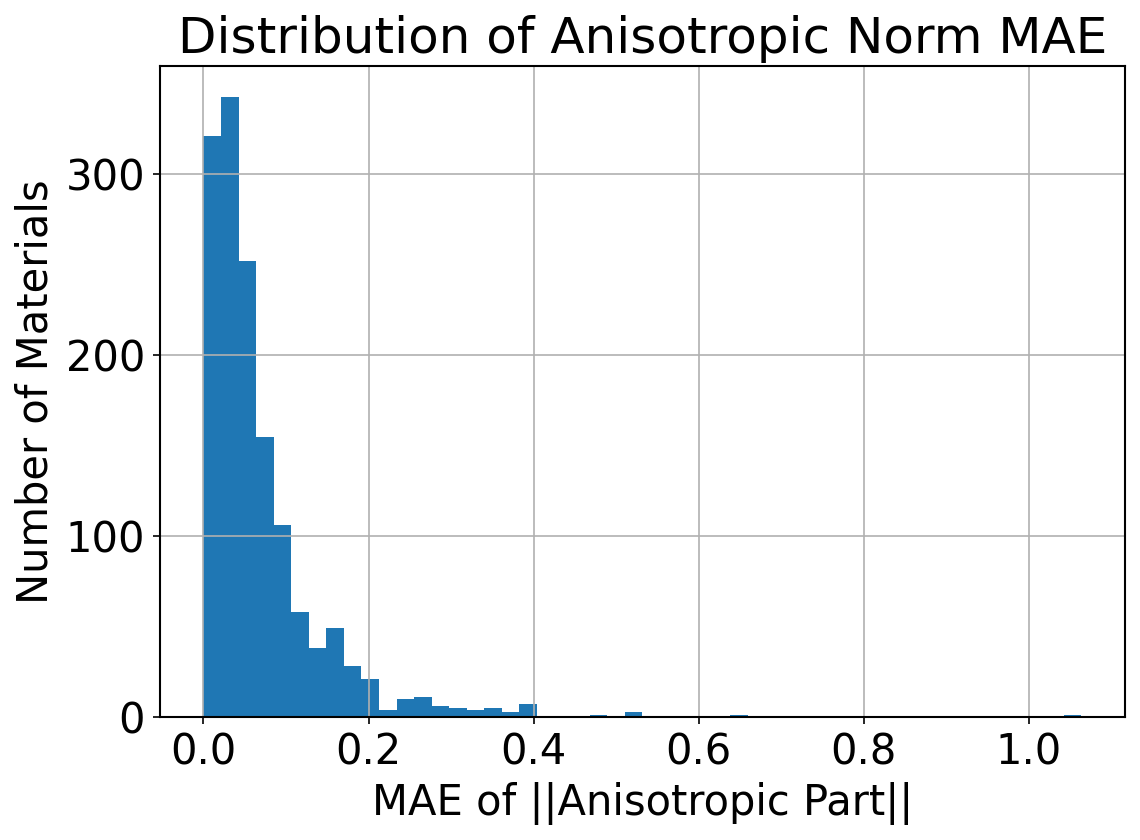

Mean MAE: 0.0669
Standard Deviation: 0.0778


In [19]:
def decompose_tensor_seq(tensor_seq):
    iso_parts = []
    aniso_parts = []
    for tensor in tensor_seq:
        iso, aniso = decompose_tensor((tensor + tensor.T.conj()) / 2)
        iso_parts.append(iso)
        aniso_parts.append(aniso)
    return np.array(iso_parts), np.array(aniso_parts)

def decompose_tensor(tensor):
    """
    Input: tensor of shape (3, 3)
    Returns: (iso_part, aniso_part), both (3, 3)
    """
    iso_scalar = np.trace(tensor) / 3
    iso_part = iso_scalar * np.eye(3)
    aniso_part = tensor - iso_part
    return iso_part, aniso_part

def anisotropy_strength(aniso_seq):
    return np.linalg.norm(aniso_seq, axis=(1,2))  # [n_freq]

def compute_aniso_mae(row):
    true_tensor = row["rel_permittivity_imag_interp"]
    pred_tensor = row["y_pred_cart"]

    true_iso, true_aniso = decompose_tensor_seq(true_tensor)
    pred_iso, pred_aniso = decompose_tensor_seq(pred_tensor)

    true_norm = anisotropy_strength(true_aniso)
    pred_norm = anisotropy_strength(pred_aniso)

    # Mask out invalid values
    mask = np.isfinite(true_norm) & np.isfinite(pred_norm)
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(true_norm[mask] - pred_norm[mask]))

df['aniso_norm_mae'] = df.apply(compute_aniso_mae, axis=1)
plt.figure(figsize=(8, 6))
df['aniso_norm_mae'].dropna().hist(bins=50)
plt.xlabel("MAE of ||Anisotropic Part||")
plt.ylabel("Number of Materials")
plt.title("Distribution of Anisotropic Norm MAE")
plt.tight_layout()
plt.show()
mean_mae = df['aniso_norm_mae'].mean()
std_mae = df['aniso_norm_mae'].std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Standard Deviation: {std_mae:.4f}")

In [20]:
df[df.split=="Test"].sample(10)

formula                              symmetrized_structure  \
690       S4Sn4  (Atom('Sn', [7.08160896, 0.989225, 1.675050912...   
391     Rb12Sb4  (Atom('Rb', [0.0, 0.0, 0.0], index=0), Atom('R...   
262    Ca2S8Sr6  (Atom('Sr', [6.32985, 8.9493, 2.10975], index=...   
660     Au16O24  (Atom('Au', [3.8648888839999995, 12.2903147640...   
1426      O2SY2  (Atom('Y', [1.8956499999999996, 1.094454037789...   
874      Na8Te4  (Atom('Na', [1.8164999999999998, 5.4495, 5.449...   
505   Cl24K8Sn4  (Atom('K', [2.505675, 2.505675, 7.517025], ind...   
834       K8Pt4  (Atom('K', [1.8907250000000004, 1.890725000000...   
675     Mg2P2S6  (Atom('Mg', [2.0578092195770252, 8.78638186385...   
937    N4Sr2Zr2  (Atom('Sr', [0.0, 2.02995, 1.1787497820000001]...   

           mp_id  bandgap crystal_system  \
690      mp-2231   0.9048   orthorhombic   
391     mp-33018   0.4313          cubic   
262   mp-1218367   2.4485   orthorhombic   
660     mp-27253   0.8690   orthorhombic   
1426    mp-12894   2.9983       trigonal   
874      mp-2784   2.0282          cubic   
505     mp-23499   2.4712          cubic   
834   mp-1062676   1.3146          cubic   
675    mp-675651   2.7986     monoclinic   
937   mp-1029275   1.2272     tetragonal   

                                                  omega      species  \
690   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...      [S, Sn]   
391   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...     [Rb, Sb]   
262   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...  [Ca, S, Sr]   
660   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...      [Au, O]   
1426  [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...    [S, Y, O]   
874   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...     [Na, Te]   
505   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...  [Sn, K, Cl]   
834   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...      [Pt, K]   
675   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...   [P, S, Mg]   
937   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...  [N, Zr, Sr]   

                        real_symmetrized_susceptibility  \
690   [[[6.430671568239582, 0.0, 0.0], [0.0, 6.68720...   
391   [[[3.772876384567803, 0.0, 0.0], [0.0, 3.77287...   
262   [[[2.094116100669524, 0.0, 0.0], [0.0, 2.09723...   
660   [[[5.639653756993397, 0.0, 0.0], [0.0, 4.86046...   
1426  [[[2.3010435364193538, 7.323023345487054e-17, ...   
874   [[[1.830943814503871, 1.6155871338926322e-27, ...   
505   [[[1.097036806430673, 5.514537417020184e-25, 5...   
834   [[[3.2318719362784907, 8.823259867232295e-24, ...   
675   [[[2.734255697802941, 0.0, -0.0008327683428514...   
937   [[[3.265787619279852, 0.0, 1.0587911840678754e...   

                        imag_symmetrized_susceptibility  \
690   [[[-3.2553740745846354e-18, 3.851859888774472e...   
391   [[[1.7016123226080867e-17, 0.0, 0.0], [0.0, 1....   
262   [[[6.316315844972629e-18, 0.0, 0.0], [0.0, 6.4...   
660   [[[-6.054287247641466e-16, 0.0, 0.0], [0.0, -7...   
1426  [[[1.3660833693790633e-18, -3.209883240645393e...   
874   [[[9.989762328142206e-18, 2.0061770254033706e-...   
505   [[[-1.5060676283024716e-17, 2.5077212817542132...   
834   [[[-7.243801486286873e-18, -1.6049416203226965...   
675   [[[-7.45998605831315e-18, 0.0, -2.185195528729...   
937   [[[-3.0866922396378716e-18, 0.0, 1.20370621524...   

                                  rel_permittivity_real  ...   mae_sph  \
690   [[[7.430671568239582, 0.0, 0.0], [0.0, 7.68720...  ...  0.085244   
391   [[[4.7728763845678035, 0.0, 0.0], [0.0, 4.7728...  ...  0.041983   
262   [[[3.094116100669524, 0.0, 0.0], [0.0, 3.09723...  ...  0.021028   
660   [[[6.639653756993397, 0.0, 0.0], [0.0, 5.86046...  ...  0.174013   
1426  [[[3.3010435364193538, 7.323023345487054e-17, ...  ...  0.101730   
874   [[[2.830943814503871, 1.6155871338926322e-27, ...  ...  0.037760   
505   [[[2.097036806430673, 5.514537417020184e-25, 5...  ...  0.032172   
834   [[[4.231871936278491, 8.823259867232295e-24, 8...  ...  0.088

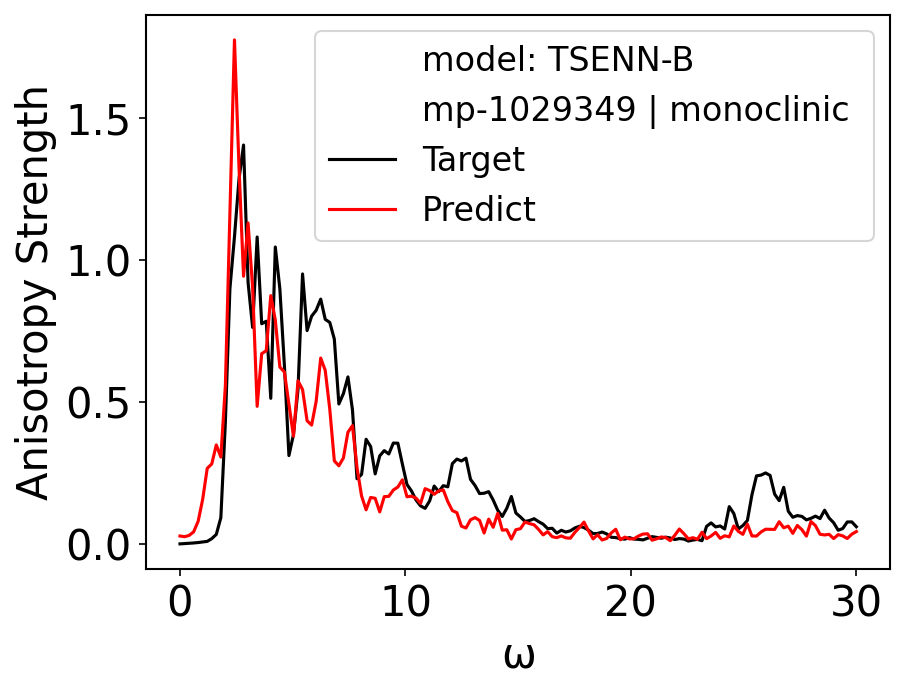

In [21]:
# row = df.iloc[1423] # cubic
# row = df.iloc[9] # monoclinic
# row = df.iloc[182] # trigonal
row = df[df.formula=="N4Se6Y8"].iloc[0]

# row = df.iloc[476] # tetragonal
true_tensor = row["rel_permittivity_imag_interp"]
pred_tensor = row["y_pred_cart"]

true_iso, true_aniso = decompose_tensor_seq(true_tensor)
pred_iso, pred_aniso = decompose_tensor_seq(pred_tensor)

true_norm = anisotropy_strength(true_aniso)
pred_norm = anisotropy_strength(pred_aniso)

# plt.title(f"{row.mp_id} | {row.crystal_system} | {row.split}")
# print(f"{row.mp_id} | {row.crystal_system} | {row.split}")
info_label = f"{row.mp_id} | {row.crystal_system} "
model_label = f"model: TSENN-B"

plt.plot([], [], ' ', label=model_label)
plt.plot([], [], ' ', label=info_label)  # dummy line for info
plt.plot(row.energies_interp, true_norm, label="Target", color='k')
plt.plot(row.energies_interp, pred_norm, label="Predict", color ='r')
plt.xlabel(f"$\omega$")
plt.ylabel(f"Anisotropy Strength")
# plt.ylim(-0.2,0.5)
plt.legend()
plt.show()


/tmp/ipykernel_626983/3797387596.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


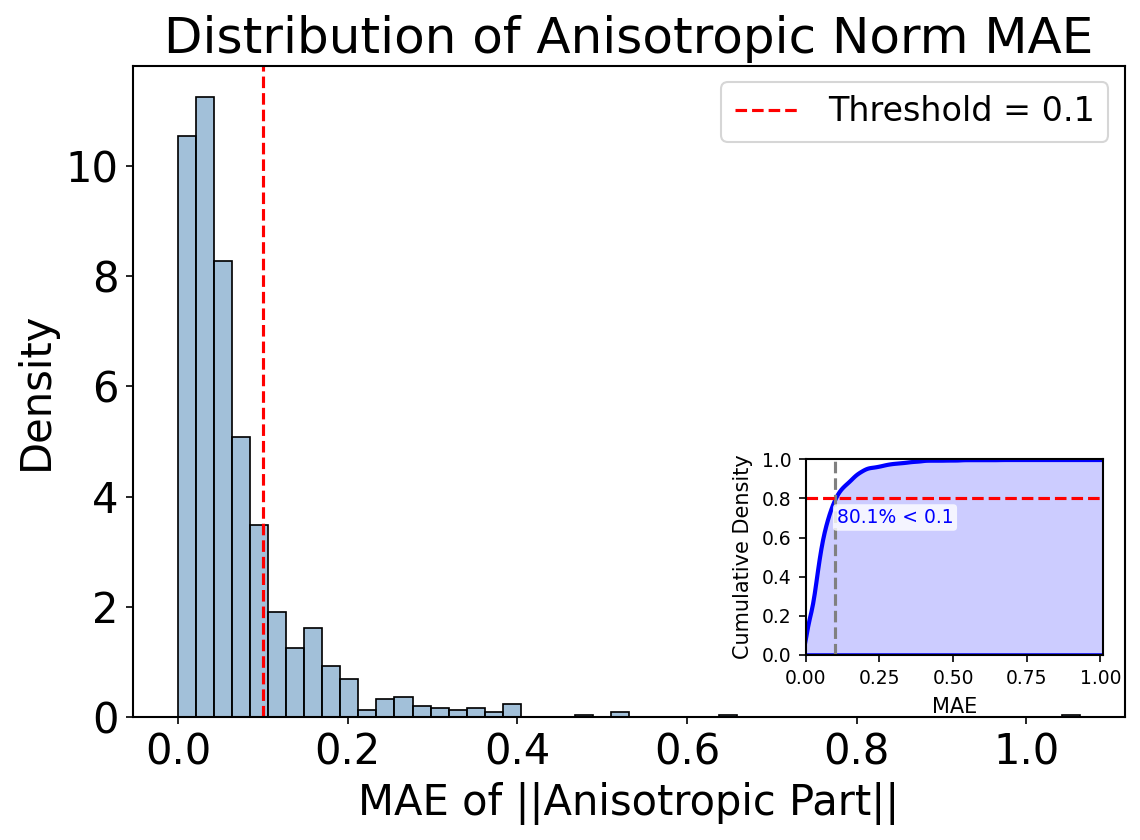

In [22]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# Ensure clean data
aniso_mae = df['aniso_norm_mae'].dropna().values
threshold = 0.1

# Create main plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(aniso_mae, bins=50, stat='density', ax=ax, color='steelblue', alpha=0.5)
ax.set_xlabel("MAE of ||Anisotropic Part||")
ax.set_ylabel("Density")
ax.set_title("Distribution of Anisotropic Norm MAE")
ax.axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
ax.legend()
# Create inset axes
inset_ax = inset_axes(ax, width="30%", height="30%", loc='lower right', 
                      bbox_to_anchor=(-0.005, 0.07, 1, 1), bbox_transform=ax.transAxes)

# KDE CDF
sns.kdeplot(aniso_mae, ax=inset_ax, color='blue', fill=True, cumulative=True,
            bw_adjust=0.5, alpha=0.2, linewidth=2)

# Axes settings
inset_ax.set_xlabel("MAE", fontsize=10)
inset_ax.set_ylabel("Cumulative Density", fontsize=10)
inset_ax.tick_params(axis='both', labelsize=9)
inset_ax.set_xlim(0, np.max(aniso_mae) * 0.95)
inset_ax.set_ylim(0, 1)

# Compute % below threshold
perc_below = np.mean(aniso_mae < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_below / 100, color='red', linestyle='--', linewidth=1.5)

inset_ax.text(threshold + 0.005, perc_below / 100 - 0.05,
              f'{perc_below:.1f}% < {threshold}',
              color='blue', fontsize=9, ha='left', va='top',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()
